In [1]:
import polars as pl
import numpy as np
from typing import List
from tqdm import tqdm

def split_df_by_week(
        origin_input_df: pl.DataFrame,
        ts_col: str = "timestamp"
) -> List[pl.DataFrame]:
    origin_input_df = origin_input_df.with_columns([
        pl.col(ts_col).cast(pl.Datetime).alias(f"{ts_col}_dt")
    ])

    origin_input_df = origin_input_df.with_columns([
        pl.col(f"{ts_col}_dt").dt.truncate("1w").alias("week_start")
    ])

    unique_weeks = origin_input_df.select("week_start").unique().sort("week_start")

    weekly_dfs = [
        origin_input_df.filter(pl.col("week_start") == wk).drop("week_start")
        for wk in unique_weeks["week_start"]
    ]

    return weekly_dfs


def clean_df_drop_nulls(
        df_to_clean: pl.DataFrame,
        null_threshold: int = 10000,
        verbose: bool = True
) -> pl.DataFrame:
    pd_df = df_to_clean.to_pandas()

    null_counts = pd_df.isnull().sum()
    cols_to_drop = null_counts[null_counts > null_threshold].index

    pd_df_cleaned = pd_df.drop(columns=cols_to_drop)
    pd_df_clean = pd_df_cleaned.dropna()
    pl_df_clean = pl.from_pandas(pd_df_clean)

    if verbose:
        max_null_col = null_counts.idxmax()
        max_null_count = null_counts.max()
        print("各列空值数量：")
        print(null_counts[null_counts > 0])
        print(f"删除空值超过 {null_threshold} 的列：{list(cols_to_drop)}")
        print(f"删除列后，DataFrame形状：{pd_df_cleaned.shape}")
        print(f"空值最多的列是：{max_null_col}，共有 {max_null_count} 个空值")
        print(f"删除空值行后，DataFrame形状：{pd_df_clean.shape}")

    return pl_df_clean

def avg_steps_to_volatility(prices: np.ndarray, target_ratio: float) -> int:
    n = len(prices)
    steps_list = []
    for i in tqdm(range(n), desc=f"cal abs change {target_ratio*100:.2f}% avg steps"):
        start_price = prices[i]
        steps = -1
        for j in range(i + 1, n):
            change = abs(prices[j] / start_price - 1)
            if change >= target_ratio:
                steps = j - i
                break
        if steps != -1:
            steps_list.append(steps)
    if len(steps_list) == 0:
        return -1
    return int(np.mean(steps_list))

def future_return_expr(price_col: str, step: int) -> pl.Expr:
    return ((pl.col(price_col).shift(-step) - pl.col(price_col)) / pl.col(price_col)).alias(f"future_return_{step}")

def rolling_minmax_scaled_expr(
        col: str,
        min_col: str,
        max_col: str,
        scaled_col: str
) -> pl.Expr:
    return (
        ((pl.col(col) - pl.col(min_col)) / (pl.col(max_col) - pl.col(min_col) + 1e-9))
        .clip(0.0, 1.0)
        .fill_null(0.5)
        .alias(scaled_col)
    )

def rolling_minmax_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')  # scaled 是最终产物，保留
           and not (
                col.endswith('_rolling_mean') or
                col.endswith('_rolling_std') or
                col.endswith('_rolling_max') or
                col.endswith('_rolling_min')
        )
    ]

    rolling_cols = []
    for column in columns_to_normalize:
        rolling_cols.extend([
            pl.col(column).rolling_max(window, min_samples=1).alias(f"{column}_rolling_max"),
            pl.col(column).rolling_min(window, min_samples=1).alias(f"{column}_rolling_min"),
        ])

    intermediate_cols = [
                            f"{column}_rolling_max" for column in columns_to_normalize
                        ] + [
                            f"{column}_rolling_min" for column in columns_to_normalize
                        ]

    return (
        rollin_df
        .with_columns(rolling_cols)
        .with_columns([
            rolling_minmax_scaled_expr(
                col=column,
                min_col=f"{column}_rolling_min",
                max_col=f"{column}_rolling_max",
                scaled_col=f"{column}_scaled"
            ) for column in columns_to_normalize
        ])
        .drop(intermediate_cols)
    )

def rolling_mean_tanh_scaled_expr(
        col: str,
        scaled_col: str,
        window: int
) -> pl.Expr:
    return (
        pl.col(col)
        .rolling_mean(window, min_samples=1)
        .tanh()
        .alias(scaled_col)
    )

def rolling_mean_tanh_normalize(rollin_df: pl.DataFrame, window: int) -> pl.DataFrame:
    columns_to_normalize = [
        col for col in rollin_df.columns
        if col not in ['px', 'timestamp', 'timestamp_dt', 'symbol']
           and not col.startswith("future_return_")
           and not col.endswith('_scaled')
    ]

    return rollin_df.with_columns([
        rolling_mean_tanh_scaled_expr(
            col=column,
            scaled_col=f"{column}_scaled",
            window=window
        ) for column in columns_to_normalize
    ])

def rolling_ic_ir_icto_index(
        df: pl.DataFrame,
        target_col: str,
        exclude_prefixes: list[str],
        window_size: int,
        step: int = 1,
) -> pl.DataFrame:
    feature_cols = [
        col for col in df.columns
        if col.endswith("_scaled") 
            and col.startswith("z_") 
            and all(not col.startswith(prefix) for prefix in exclude_prefixes)
            and not col.startswith("future_return_")
            and col != "px"
    ]

    # feature_cols = [
    #     col for col in df.columns
    #     if col.startswith("z_") 
    #         and all(not col.startswith(prefix) for prefix in exclude_prefixes)
    #         and not col.startswith("future_return_")
    #         and col != "px"
    # ]

    n = df.height
    results = []
    prev_ranks = {}

    for start in tqdm(range(0, n - window_size + 1, step), desc="Rolling IC & ICTO"):
        end = start + window_size
        df_win = df.slice(start, window_size)

        # rank 转换
        df_ranked = df_win.with_columns([
            (pl.col(c).rank(method="average") / window_size).alias(c + "_rank") for c in feature_cols + [target_col]
        ])
        target_rank_col = target_col + "_rank"

        for feat in feature_cols:
            feat_rank_col = feat + "_rank"
            ic = df_ranked.select(
                pl.corr(pl.col(feat_rank_col), pl.col(target_rank_col)).alias("ic")
            ).to_series()[0]

            turnover = None
            if feat in prev_ranks:
                cur_ranks = df_ranked[feat_rank_col].to_numpy()
                prev = prev_ranks[feat]
                if len(prev) == len(cur_ranks):
                    turnover = np.mean(np.abs(cur_ranks - prev))

            # 更新 prev_ranks
            prev_ranks[feat] = df_ranked[feat_rank_col].to_numpy()

            results.append({
                "window_start": int(start),
                "window_end": int(end - 1),
                "factor": str(feat),
                "ic": float(ic) if not np.isnan(ic) else None,
                "turnover": float(turnover) if turnover is not None else None
            })

    df_result = pl.DataFrame(
        results,
        schema={
            "window_start": pl.Int64,
            "window_end": pl.Int64,
            "factor": pl.Utf8,
            "ic": pl.Float64,
            "turnover": pl.Float64,
        }
    )      
    return (
        df_result
        .group_by("factor")
        .agg([
            pl.mean("ic").alias("mean_ic"),
            pl.std("ic").alias("std_ic"),
            pl.mean("turnover").alias("mean_turnover")
        ])
        .with_columns([
            (pl.col("mean_ic") / pl.col("std_ic")).alias("ir"),
            (pl.col("mean_ic") / (pl.col("mean_turnover") + 1e-8)).abs().alias("icto")
        ])
        .sort("icto", descending=True)
    )

In [2]:
origin_df = pl.read_csv("C:/quant/data/binance_resampled_data/BTCUSDT_factors_threshold0.001_rolling2000.csv")
print(origin_df)

shape: (22_986, 94)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────┬────────────────────┬────────────────────┬────────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_oi_breakou ┆ z_factor_momentum_ ┆ z_factor_order_sen ┆ z_factor_oi_moment │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ t_signal            ┆ trend_confir…      ┆ timent_diver…      ┆ um_punch           │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                 ┆ ---                ┆ ---                ┆ ---                │
│                  ┆          ┆            ┆             ┆   ┆ f64                 ┆ f64                ┆ f64                ┆ f64                │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ 1744068097399000 ┆ 79746.7  ┆ 55.71      ┆ 50.115      ┆ … ┆ -0.050053           ┆ -0.0754

In [3]:
avg_steps_pct = 200

origin_df = origin_df.with_columns([
    future_return_expr("px", avg_steps_pct),
])
print(origin_df)

origin_df = rolling_mean_tanh_normalize(origin_df, 700)
origin_df = clean_df_drop_nulls(origin_df)

weekly_dataframes = split_df_by_week(origin_df)
print("num weekly dfs: ", len(weekly_dataframes))

shape: (22_986, 95)
┌──────────────────┬──────────┬────────────┬─────────────┬───┬─────────────────────┬─────────────────────┬────────────────────┬───────────────────┐
│ timestamp        ┆ px       ┆ sum_buy_sz ┆ sum_sell_sz ┆ … ┆ z_factor_momentum_t ┆ z_factor_order_sent ┆ z_factor_oi_moment ┆ future_return_200 │
│ ---              ┆ ---      ┆ ---        ┆ ---         ┆   ┆ rend_confir…        ┆ iment_diver…        ┆ um_punch           ┆ ---               │
│ i64              ┆ f64      ┆ f64        ┆ f64         ┆   ┆ ---                 ┆ ---                 ┆ ---                ┆ f64               │
│                  ┆          ┆            ┆             ┆   ┆ f64                 ┆ f64                 ┆ f64                ┆                   │
╞══════════════════╪══════════╪════════════╪═════════════╪═══╪═════════════════════╪═════════════════════╪════════════════════╪═══════════════════╡
│ 1744068097399000 ┆ 79746.7  ┆ 55.71      ┆ 50.115      ┆ … ┆ -0.075475           ┆ -0.2842

In [4]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture

import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
import torch

import numpy as np
import matplotlib.pyplot as plt

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_last_n_rows_with_px(y_test, y_test_binary, y_pred_prob, px, n=700):
    # 截取最后 n 行
    y_test_slice = y_test[-n:]
    y_test_binary_slice = y_test_binary[-n:]
    y_pred_prob_slice = y_pred_prob[-n:]
    px_slice = px[-n:]

    time_index = np.arange(len(y_test_slice))

    fig, ax1 = plt.subplots(figsize=(16, 7))

    # 原始收益
    ax1.plot(time_index, y_test_slice, label="Original Future Returns", color='gray', alpha=0.8)
    ax1.set_ylabel("Original Future Returns", color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # GMM 标签
    ax2 = ax1.twinx()
    ax2.scatter(time_index, y_test_binary_slice, label="GMM Labels", color='tab:blue', marker='o', s=20, alpha=0.7)
    ax2.set_ylabel("GMM Labels (0 or 1)", color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim(-0.1, 1.1)

    # 模型预测概率
    ax3 = ax1.twinx()
    ax3.spines.right.set_position(("outward", 60))
    ax3.plot(time_index, y_pred_prob_slice, label="MODEL Predicted Probability", color='tab:green', alpha=0.4)
    ax3.set_ylabel("MODEL Predicted Probability", color='tab:green')
    ax3.tick_params(axis='y', labelcolor='tab:green')
    ax3.set_ylim(-0.05, 1.05)

    # 加价格线 (第4轴)
    ax4 = ax1.twinx()
    ax4.spines.right.set_position(("outward", 120))  # 再右移一层
    ax4.plot(time_index, px_slice, label="Price (px)", color='tab:red', linestyle='--', alpha=0.6)
    ax4.set_ylabel("Price (px)", color='tab:red')
    ax4.tick_params(axis='y', labelcolor='tab:red')

    # x轴
    ax1.set_xlabel("Time Index")
    plt.title(f"Compare Returns, Labels, Prediction & Price (Last {n} Rows)")

    # 图例
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    lines_3, labels_3 = ax3.get_legend_handles_labels()
    lines_4, labels_4 = ax4.get_legend_handles_labels()

    ax1.legend(
        lines_1 + lines_2 + lines_3 + lines_4,
        labels_1 + labels_2 + labels_3 + labels_4,
        loc='upper left'
    )

    plt.tight_layout()
    plt.show()


In [6]:
from sklearn.mixture import GaussianMixture
import numpy as np

def gmm_label_binarize(y_train, y_val=None, y_test=None, verbose=True, random_state=42):
    """
    用 GMM 对收益率进行聚类，然后按均值高低映射为上涨(1)/下跌(0)标签。
    
    参数:
        y_train, y_val, y_test: Series 或 ndarray
        verbose: 是否打印详细映射信息
    返回:
        y_train_binary, y_val_binary, y_test_binary, gmm_model
    """
    y_train_np = np.asarray(y_train).reshape(-1, 1)
    y_val_np = np.asarray(y_val).reshape(-1, 1) if y_val is not None else None
    y_test_np = np.asarray(y_test).reshape(-1, 1) if y_test is not None else None

    # GMM 拟合
    gmm = GaussianMixture(n_components=2, random_state=random_state)
    gmm.fit(y_train_np)

    means = gmm.means_.flatten()
    upward_label = np.argmax(means)
    downward_label = np.argmin(means)

    if verbose:
        print(f"GMM 分量均值: {means}")
        print(f"上涨标签: {upward_label}, 下跌标签: {downward_label}")

    # 标签转换函数
    def transform_labels(y_np):
        raw = gmm.predict(y_np)
        binary = (raw == upward_label).astype(int)
        return binary, raw

    y_train_binary, train_raw = transform_labels(y_train_np)
    y_val_binary, val_raw = transform_labels(y_val_np) if y_val_np is not None else (None, None)
    y_test_binary, test_raw = transform_labels(y_test_np) if y_test_np is not None else (None, None)

    if verbose:
        print("\n--- GMM 原始标签 => 最终二元标签映射 ---")
        for label in [0, 1]:
            print(f"GMM 内部标签 {label} (均值: {means[label]:.6f}) => 二元标签: {1 if label == upward_label else 0}")

        print("\n--- 示例标签 ---")
        print("训练集原始收益:", y_train_np[:10].flatten())
        print("训练集GMM标签:", train_raw[:10])
        print("训练集二元标签:", y_train_binary[:10])

        if y_test_binary is not None:
            print("\n测试集原始收益:", y_test_np[:10].flatten())
            print("测试集GMM标签:", test_raw[:10])
            print("测试集二元标签:", y_test_binary[:10])

    return y_train_binary, y_val_binary, y_test_binary, gmm


In [7]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_with_confidence(
    y_true,
    y_pred_proba,                      
    model_name="Model",                    
    lower_thresh=0.15,                  
    upper_thresh=0.85,       
    print_report=True,
):

    # ===== 基础评估 (全样本) =====
    base_pred = (y_pred_proba >= 0.5).astype(int)
    base_acc = accuracy_score(y_true, base_pred)
    
    # ===== 置信预测评估 =====
    # 生成交易信号 (-1: 不交易, 0: 做空, 1: 做多)
    signals = np.full_like(y_pred_proba, fill_value=-1, dtype=int)
    signals[y_pred_proba <= lower_thresh] = 0
    signals[y_pred_proba >= upper_thresh] = 1
    
    # 计算置信预测指标
    mask = signals != -1
    conf_acc = accuracy_score(y_true[mask], signals[mask]) if any(mask) else np.nan
    trading_rate = mask.mean()
    
    # ===== 结果组织 =====
    eval_dict = {
        'model': model_name,
        'thresholds': f"{lower_thresh}-{upper_thresh}",
        'base_accuracy': base_acc,
        'confident_accuracy': conf_acc,
        'trading_rate': trading_rate,
        'conf_matrix': confusion_matrix(y_true[mask], signals[mask]) if any(mask) else None,
        'class_report': classification_report(y_true[mask], signals[mask], output_dict=True) if any(mask) else None,
        'y_test_binary': y_true, 
        'y_pred_proba': y_pred_proba, 
        'signal': signals,
    }
    
    # ===== 打印输出 =====
    if print_report:
        print(f"\n=== {model_name} 评估结果 ===")
        print(f"📊 全样本准确率: {base_acc:.4f}")
        print(f"✅ 自信预测准确率: {conf_acc:.4f} (阈值 {lower_thresh}-{upper_thresh})")
        print(f"📈 出手率: {trading_rate:.2%}")
        
        if any(mask):
            print("\n🧮 自信预测混淆矩阵:")
            print(eval_dict['conf_matrix'])
            
            print("\n📝 分类报告:")
            print(classification_report(y_true[mask], signals[mask]))
        else:
            print("⚠️ 无自信预测样本!")
    
    return eval_dict


In [8]:
def evaluate_and_plot(model, name, X_val, y_val, X_test, y_test, y_val_bin, y_test_bin, px_val, px_test):
    val_pred = model.predict_proba(X_val)[:, 1]
    test_pred = model.predict_proba(X_test)[:, 1]
    
    val_eval = evaluate_with_confidence(
        y_true=y_val_bin,
        y_pred_proba=val_pred,
        model_name=f"{name} (Val)",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val_bin, val_pred, px_val, n=2000)

    test_eval = evaluate_with_confidence(
        y_true=y_test_bin,
        y_pred_proba=test_pred,
        model_name=f"{name} (Test)",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test_bin, test_pred, px_test, n=6199)

    return {'val': val_eval, 'test': test_eval}


Fold 0: Train 0~2, Val 3, Test 4
Train: 2025-04-07 23:21:37.399000 to 2025-04-27 23:56:42.096000
Val: 2025-04-28 00:06:59.957000 to 2025-05-04 23:55:19.066000
Test: 2025-05-05 00:01:39.539000 to 2025-05-11 23:57:01.156000
GMM 分量均值: [ 0.01160973 -0.00456814]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.011610) => 二元标签: 1
GMM 内部标签 1 (均值: -0.004568) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [-7.02223415e-05  1.00427696e-05 -1.25404587e-06  2.05367421e-03
 -1.25399240e-06 -2.01940736e-03 -2.01517589e-03  4.26793600e-05
  4.90050714e-05 -2.51560303e-06]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [ 0.00368397  0.00369302  0.00160607 -0.0004681  -0.00256658 -0.00250895
 -0.00455572 -0.00659495 -0.00867212 -0.00654371]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76061 | val_0_accuracy: 0.64426 |  0:00:00s
epoch 1  | loss: 0.58811 | val_0_accuracy: 0.54407 |  0:00:01s
epoch 2  | loss: 0.5486  | val_0_accuracy: 0.69626 |  0:00:02s
epoch 3  | loss: 0.52588 | val_0_accuracy: 0.67089 |  0:00:03s
epoch 4  | loss: 0.52054 | val_0_accuracy: 0.64363 |  0:00:04s
epoch 5  | loss: 0.48412 | val_0_accuracy: 0.49715 |  0:00:05s
epoch 6  | loss: 0.4601  | val_0_accuracy: 0.64363 |  0:00:06s
epoch 7  | loss: 0.41921 | val_0_accuracy: 0.64046 |  0:00:07s
epoch 8  | loss: 0.44738 | val_0_accuracy: 0.71211 |  0:00:08s
epoch 9  | loss: 0.44458 | val_0_accuracy: 0.78503 |  0:00:09s
epoch 10 | loss: 0.40589 | val_0_accuracy: 0.62397 |  0:00:10s
epoch 11 | loss: 0.35753 | val_0_accuracy: 0.64236 |  0:00:10s
epoch 12 | loss: 0.36542 | val_0_accuracy: 0.62143 |  0:00:11s
epoch 13 | loss: 0.36584 | val_0_accuracy: 0.61699 |  0:00:12s
epoch 14 | loss: 0.35524 | val_0_accuracy: 0.65885 |  0:00:13s
epoch 15 | loss: 0.34332 | val_0_accuracy: 0.70831 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.8237
✅ 自信预测准确率: 0.9482 (阈值 0.15-0.85)
📈 出手率: 29.36%

🧮 自信预测混淆矩阵:
[[251   2]
 [ 22 188]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       253
           1       0.99      0.90      0.94       210

    accuracy                           0.95       463
   macro avg       0.95      0.94      0.95       463
weighted avg       0.95      0.95      0.95       463



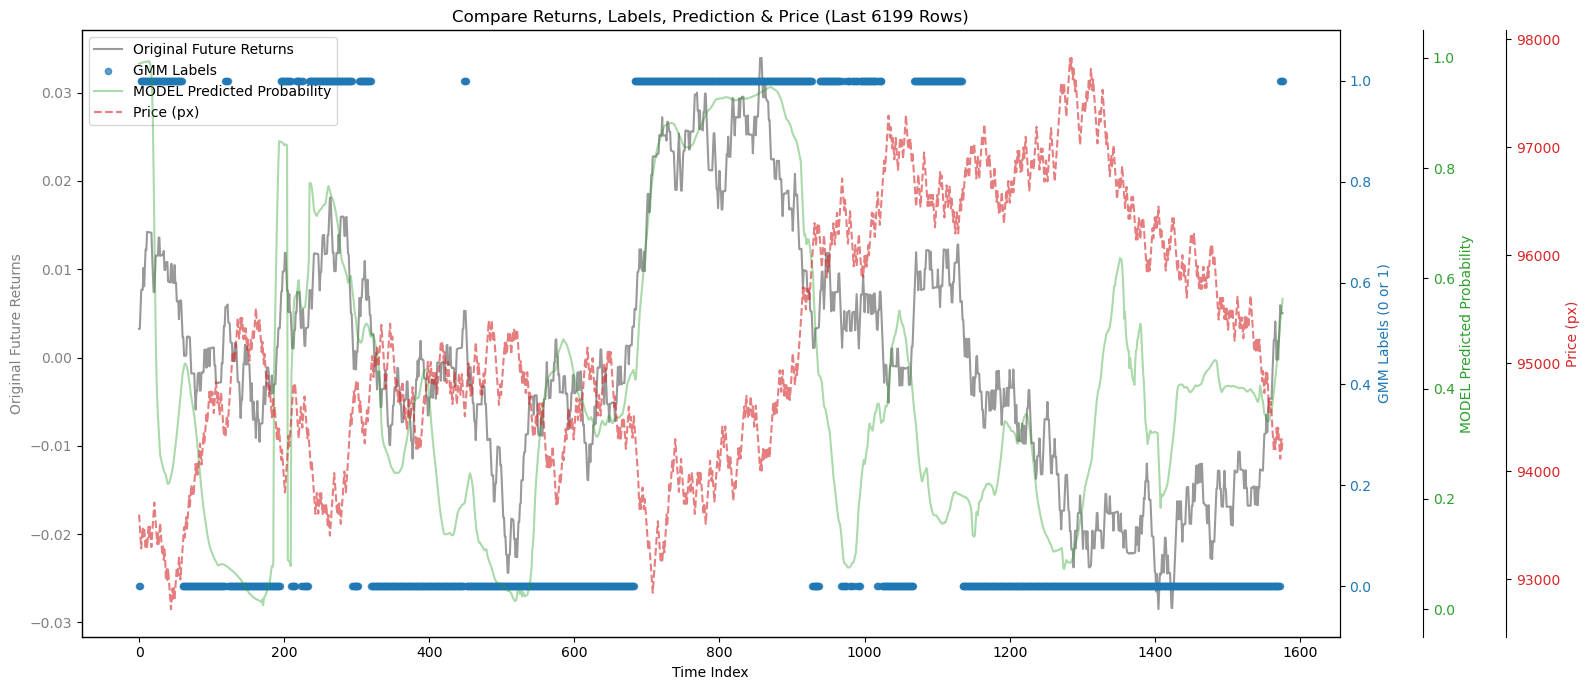


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5338
✅ 自信预测准确率: 0.6060 (阈值 0.15-0.85)
📈 出手率: 62.96%

🧮 自信预测混淆矩阵:
[[507 210]
 [344 345]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       717
           1       0.62      0.50      0.55       689

    accuracy                           0.61      1406
   macro avg       0.61      0.60      0.60      1406
weighted avg       0.61      0.61      0.60      1406



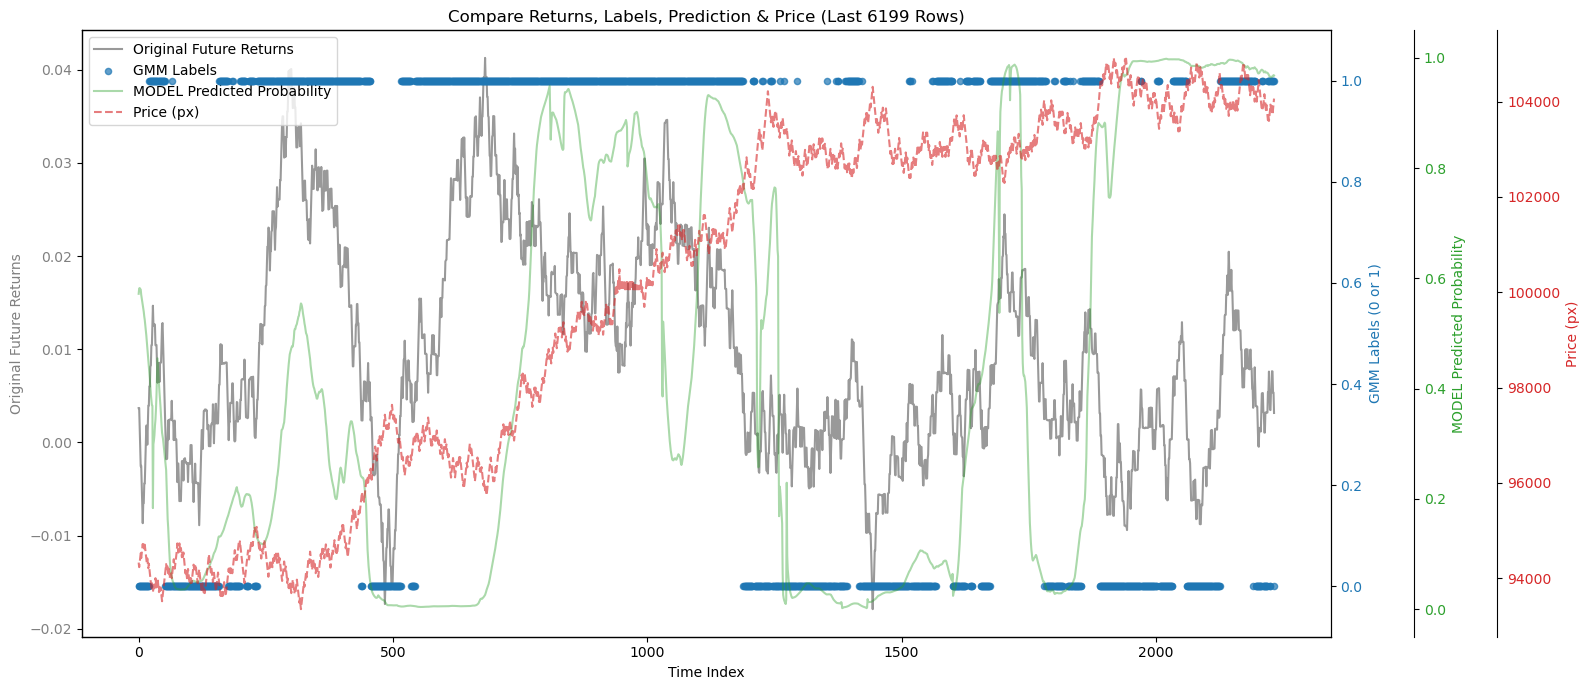

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.76061 | val_0_accuracy: 0.64426 |  0:00:00s
epoch 1  | loss: 0.58811 | val_0_accuracy: 0.54407 |  0:00:01s
epoch 2  | loss: 0.5486  | val_0_accuracy: 0.69626 |  0:00:02s
epoch 3  | loss: 0.52588 | val_0_accuracy: 0.67089 |  0:00:03s
epoch 4  | loss: 0.52054 | val_0_accuracy: 0.64363 |  0:00:04s
epoch 5  | loss: 0.48412 | val_0_accuracy: 0.49715 |  0:00:04s
epoch 6  | loss: 0.4601  | val_0_accuracy: 0.64363 |  0:00:05s
epoch 7  | loss: 0.41921 | val_0_accuracy: 0.64046 |  0:00:06s
epoch 8  | loss: 0.44738 | val_0_accuracy: 0.71211 |  0:00:07s
epoch 9  | loss: 0.44458 | val_0_accuracy: 0.78503 |  0:00:08s
epoch 10 | loss: 0.40589 | val_0_accuracy: 0.62397 |  0:00:09s
epoch 11 | loss: 0.35753 | val_0_accuracy: 0.64236 |  0:00:09s
epoch 12 | loss: 0.36542 | val_0_accuracy: 0.62143 |  0:00:10s
epoch 13 | loss: 0.36584 | val_0_accuracy: 0.61699 |  0:00:11s
epoch 14 | loss: 0.35524 | val_0_accuracy: 0.65885 |  0:00:12s
epoch 15 | loss: 0.34332 | val_0_accuracy: 0.70831 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tab_inc 评估结果 ===
📊 全样本准确率: 0.8237
✅ 自信预测准确率: 0.9482 (阈值 0.15-0.85)
📈 出手率: 29.36%

🧮 自信预测混淆矩阵:
[[251   2]
 [ 22 188]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95       253
           1       0.99      0.90      0.94       210

    accuracy                           0.95       463
   macro avg       0.95      0.94      0.95       463
weighted avg       0.95      0.95      0.95       463



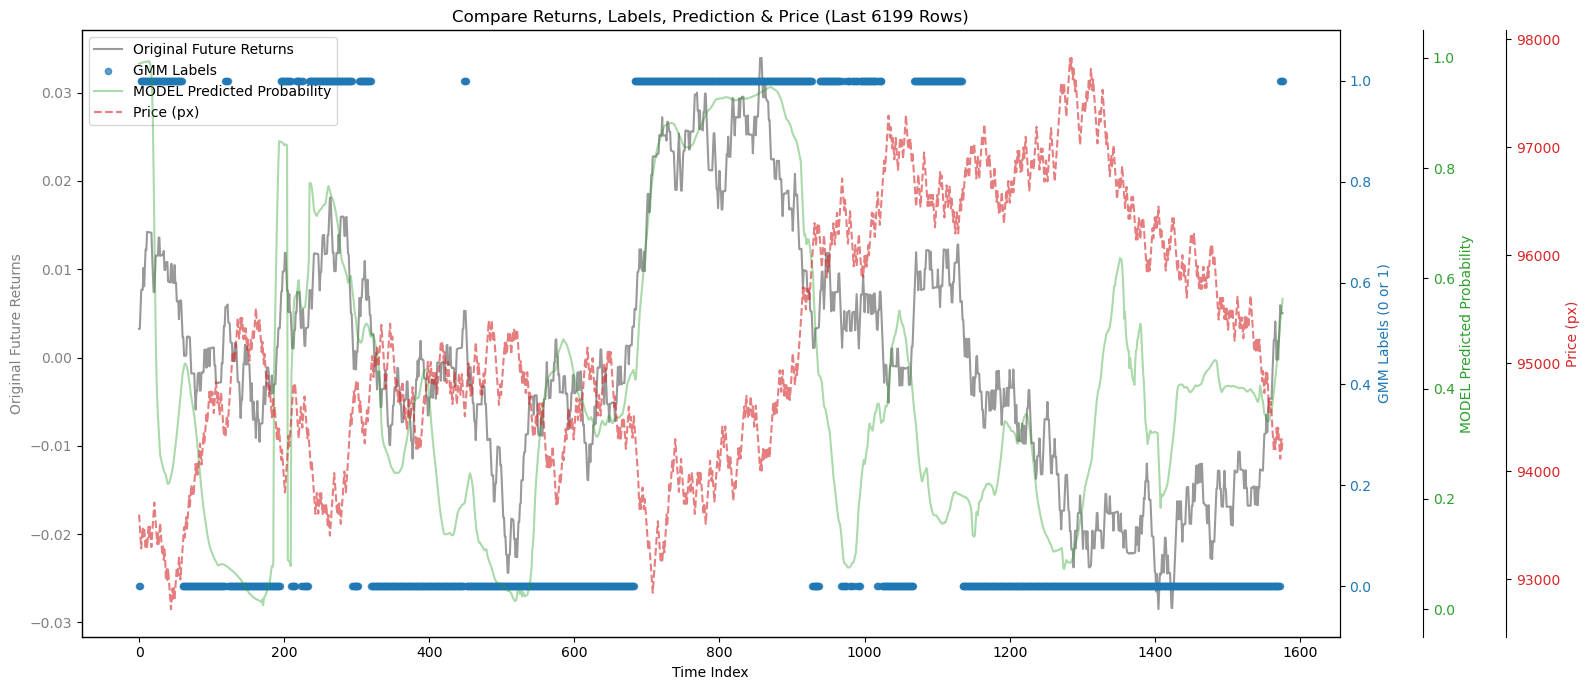


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5338
✅ 自信预测准确率: 0.6060 (阈值 0.15-0.85)
📈 出手率: 62.96%

🧮 自信预测混淆矩阵:
[[507 210]
 [344 345]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.60      0.71      0.65       717
           1       0.62      0.50      0.55       689

    accuracy                           0.61      1406
   macro avg       0.61      0.60      0.60      1406
weighted avg       0.61      0.61      0.60      1406



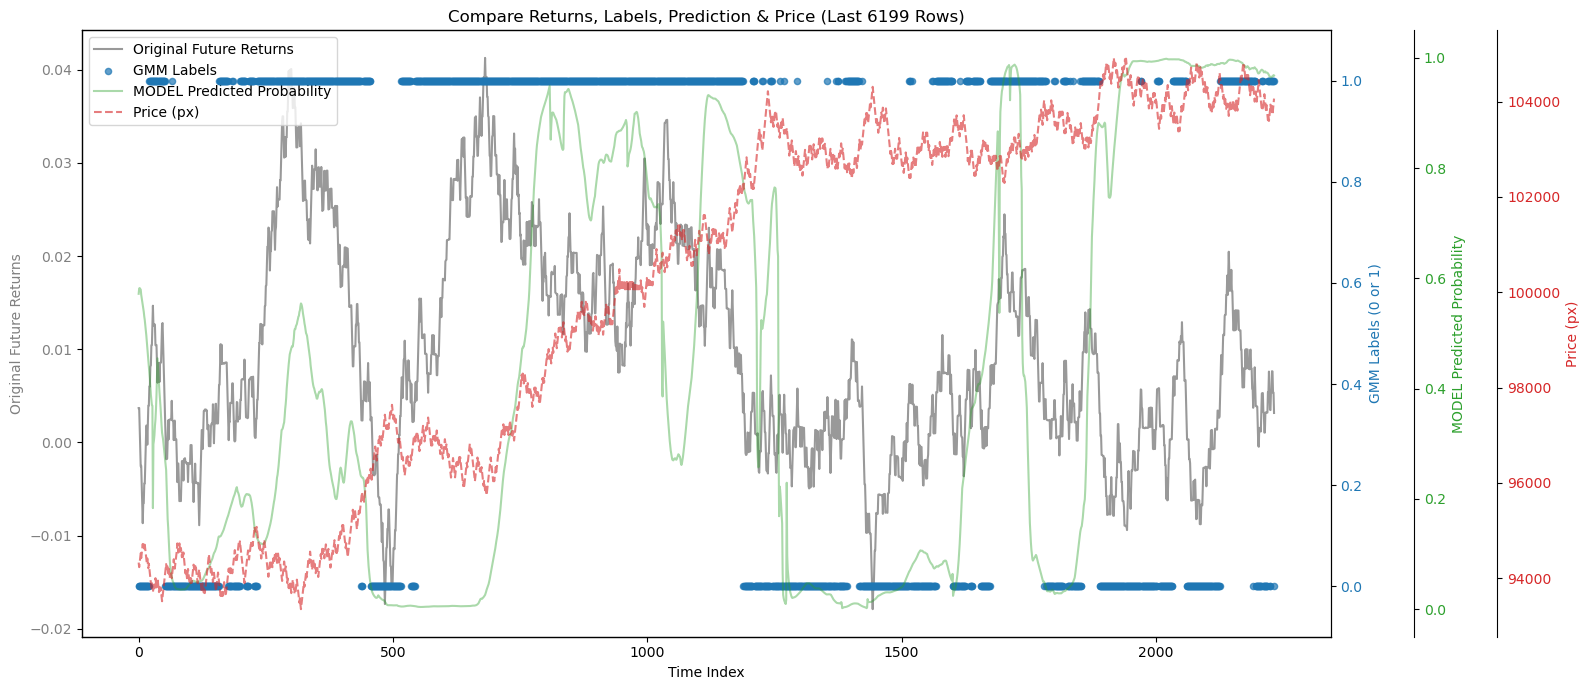

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.2068  |  0:00:00s
epoch 1  | loss: 0.80868 |  0:00:00s
epoch 2  | loss: 0.54551 |  0:00:00s
epoch 3  | loss: 0.46949 |  0:00:00s
epoch 4  | loss: 0.48821 |  0:00:00s
epoch 5  | loss: 0.37467 |  0:00:00s
epoch 6  | loss: 0.33942 |  0:00:00s
epoch 7  | loss: 0.33937 |  0:00:00s
epoch 8  | loss: 0.28855 |  0:00:00s
epoch 9  | loss: 0.30121 |  0:00:00s
epoch 10 | loss: 0.29904 |  0:00:00s
epoch 11 | loss: 0.26929 |  0:00:00s
epoch 12 | loss: 0.26178 |  0:00:00s
epoch 13 | loss: 0.25352 |  0:00:00s
epoch 14 | loss: 0.25371 |  0:00:00s
epoch 15 | loss: 0.28286 |  0:00:00s
epoch 16 | loss: 0.25215 |  0:00:00s
epoch 17 | loss: 0.25241 |  0:00:00s
epoch 18 | loss: 0.23456 |  0:00:00s
epoch 19 | loss: 0.18919 |  0:00:00s
epoch 20 | loss: 0.20714 |  0:00:00s
epoch 21 | loss: 0.19169 |  0:00:00s
epoch 22 | loss: 0.20307 |  0:00:01s
epoch 23 | loss: 0.19253 |  0:00:01s
epoch 24 | loss: 0.18761 |  0:00:01s
epoch 25 | loss: 0.20642 |  0:00:01s
epoch 26 | loss: 0.17491 |  0:00:01s
e

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7933  | val_0_accuracy: 0.59203 |  0:00:00s
epoch 1  | loss: 0.5493  | val_0_accuracy: 0.59427 |  0:00:01s
epoch 2  | loss: 0.50022 | val_0_accuracy: 0.4635  |  0:00:01s
epoch 3  | loss: 0.48931 | val_0_accuracy: 0.42857 |  0:00:02s
epoch 4  | loss: 0.45025 | val_0_accuracy: 0.52754 |  0:00:02s
epoch 5  | loss: 0.45795 | val_0_accuracy: 0.51097 |  0:00:03s
epoch 6  | loss: 0.4422  | val_0_accuracy: 0.53605 |  0:00:03s
epoch 7  | loss: 0.42898 | val_0_accuracy: 0.45678 |  0:00:04s
epoch 8  | loss: 0.40872 | val_0_accuracy: 0.46171 |  0:00:04s
epoch 9  | loss: 0.40594 | val_0_accuracy: 0.46037 |  0:00:05s
epoch 10 | loss: 0.41983 | val_0_accuracy: 0.485   |  0:00:05s
epoch 11 | loss: 0.38615 | val_0_accuracy: 0.47291 |  0:00:06s
epoch 12 | loss: 0.34118 | val_0_accuracy: 0.45678 |  0:00:07s
epoch 13 | loss: 0.33134 | val_0_accuracy: 0.45678 |  0:00:07s
epoch 14 | loss: 0.3116  | val_0_accuracy: 0.47873 |  0:00:08s
epoch 15 | loss: 0.31259 | val_0_accuracy: 0.53695 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6198
✅ 自信预测准确率: 0.6176 (阈值 0.15-0.85)
📈 出手率: 88.89%

🧮 自信预测混淆矩阵:
[[772 199]
 [560 454]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.58      0.80      0.67       971
           1       0.70      0.45      0.54      1014

    accuracy                           0.62      1985
   macro avg       0.64      0.62      0.61      1985
weighted avg       0.64      0.62      0.61      1985



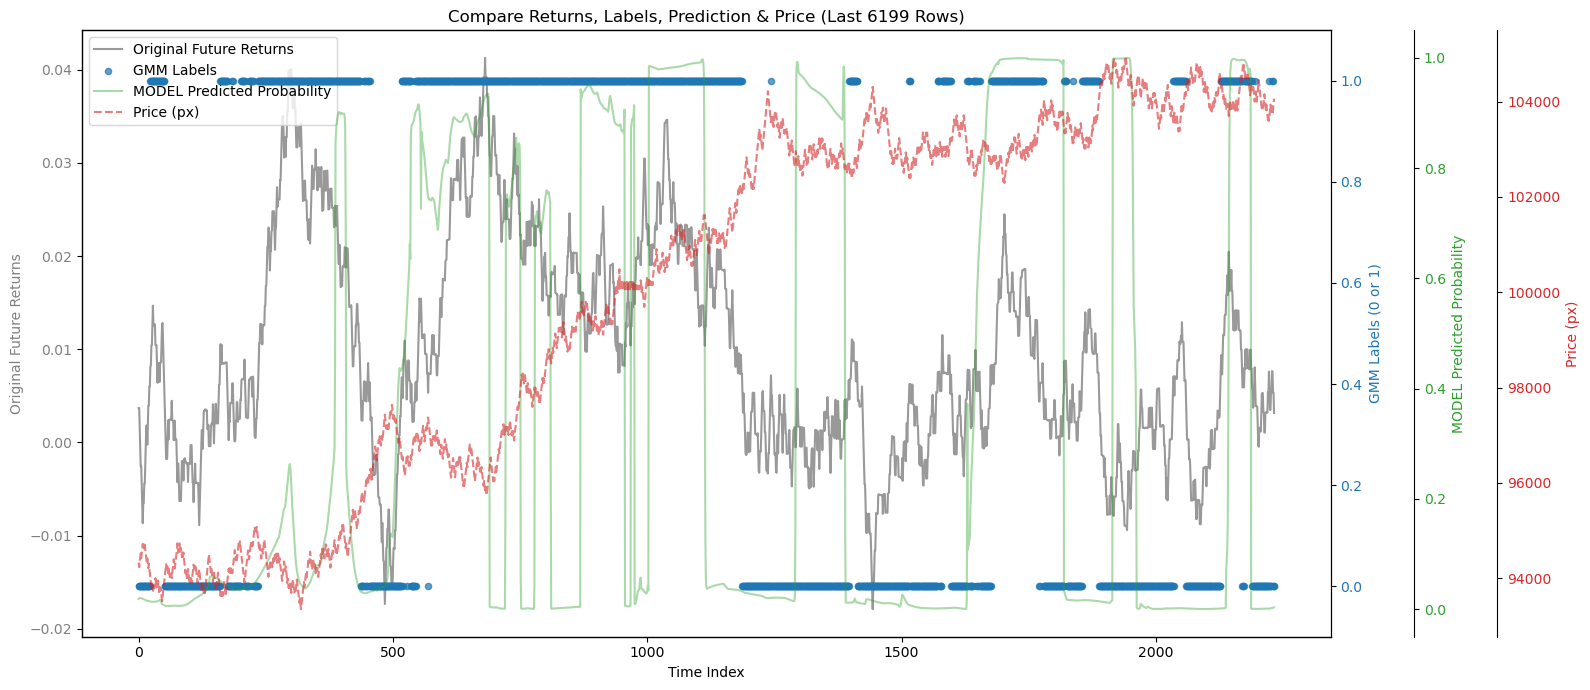


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5181
✅ 自信预测准确率: 0.4744 (阈值 0.15-0.85)
📈 出手率: 64.14%

🧮 自信预测混淆矩阵:
[[549 399]
 [309  90]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61       948
           1       0.18      0.23      0.20       399

    accuracy                           0.47      1347
   macro avg       0.41      0.40      0.41      1347
weighted avg       0.50      0.47      0.49      1347



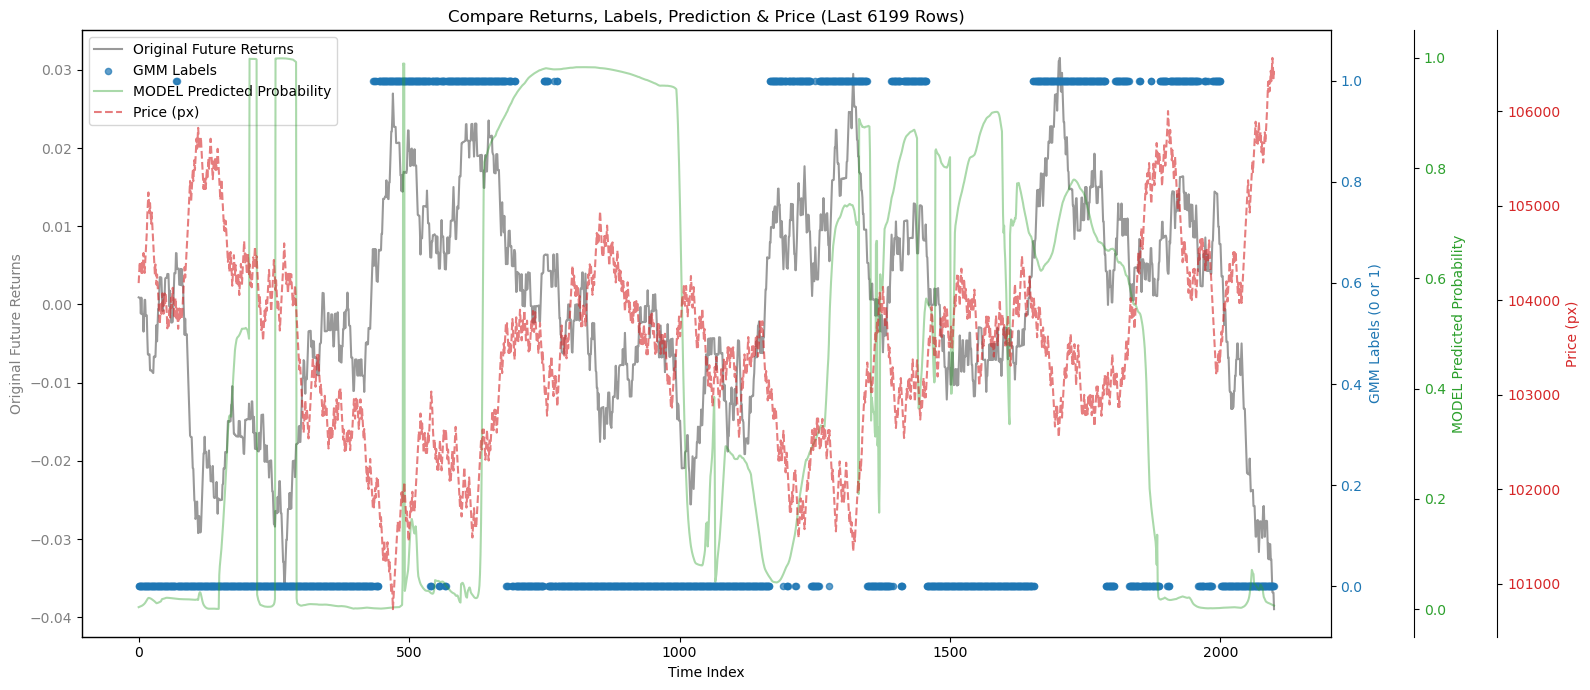

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.90174 |  0:00:00s
epoch 1  | loss: 0.63771 |  0:00:00s
epoch 2  | loss: 0.55814 |  0:00:00s
epoch 3  | loss: 0.48059 |  0:00:00s
epoch 4  | loss: 0.39133 |  0:00:00s
epoch 5  | loss: 0.41181 |  0:00:00s
epoch 6  | loss: 0.36476 |  0:00:00s
epoch 7  | loss: 0.33603 |  0:00:00s
epoch 8  | loss: 0.32572 |  0:00:00s
epoch 9  | loss: 0.31325 |  0:00:00s
epoch 10 | loss: 0.30825 |  0:00:01s
epoch 11 | loss: 0.2979  |  0:00:01s
epoch 12 | loss: 0.27265 |  0:00:01s
epoch 13 | loss: 0.26529 |  0:00:01s
epoch 14 | loss: 0.2569  |  0:00:01s
epoch 15 | loss: 0.27763 |  0:00:01s
epoch 16 | loss: 0.27206 |  0:00:01s
epoch 17 | loss: 0.2661  |  0:00:01s
epoch 18 | loss: 0.27615 |  0:00:01s
epoch 19 | loss: 0.25987 |  0:00:01s
epoch 20 | loss: 0.24028 |  0:00:01s
epoch 21 | loss: 0.22813 |  0:00:02s
epoch 22 | loss: 0.22552 |  0:00:02s
epoch 23 | loss: 0.2302  |  0:00:02s
epoch 24 | loss: 0.227   |  0:00:02s
epoch 25 | loss: 0.21162 |  0:00:02s
epoch 26 | loss: 0.21624 |  0:00:02s
e

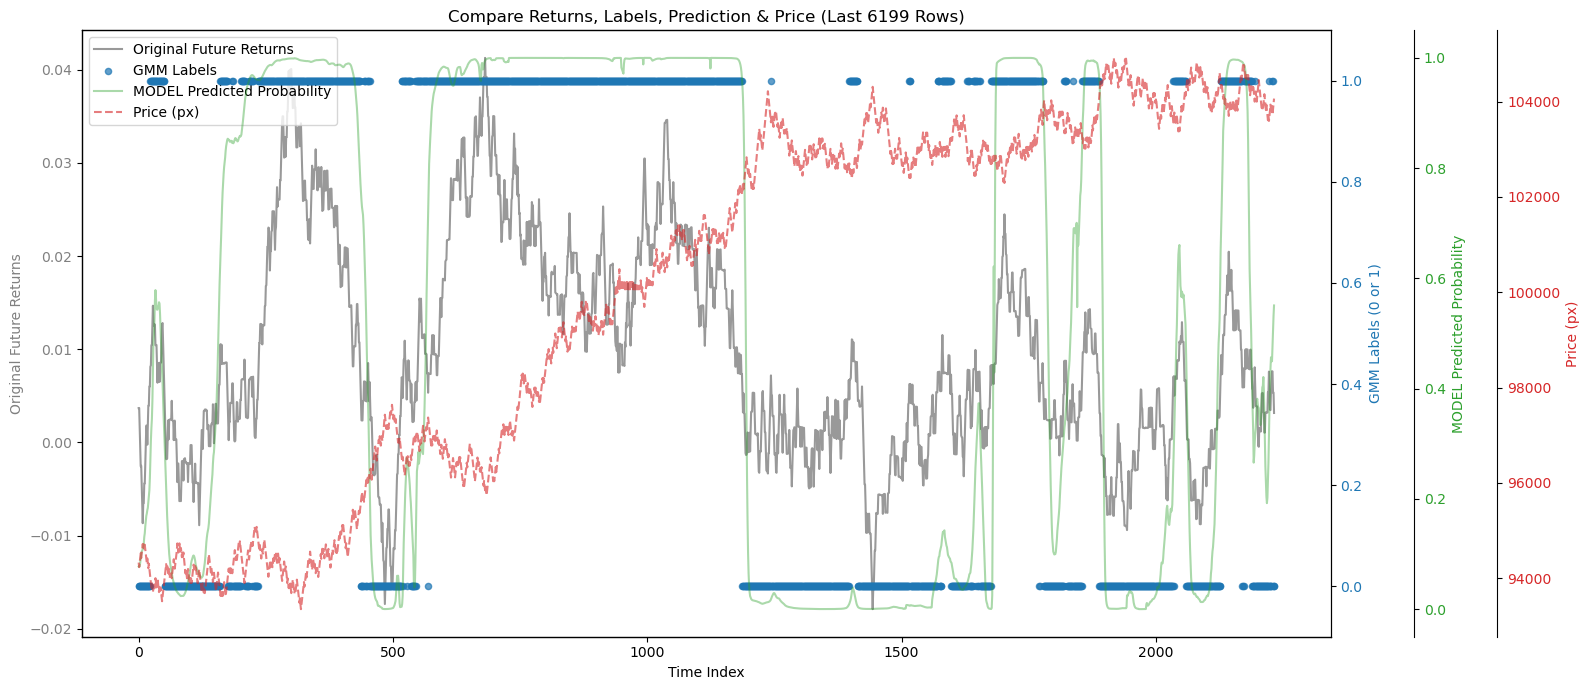


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5481
✅ 自信预测准确率: 0.5336 (阈值 0.15-0.85)
📈 出手率: 92.19%

🧮 自信预测混淆矩阵:
[[462 771]
 [132 571]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.78      0.37      0.51      1233
           1       0.43      0.81      0.56       703

    accuracy                           0.53      1936
   macro avg       0.60      0.59      0.53      1936
weighted avg       0.65      0.53      0.52      1936



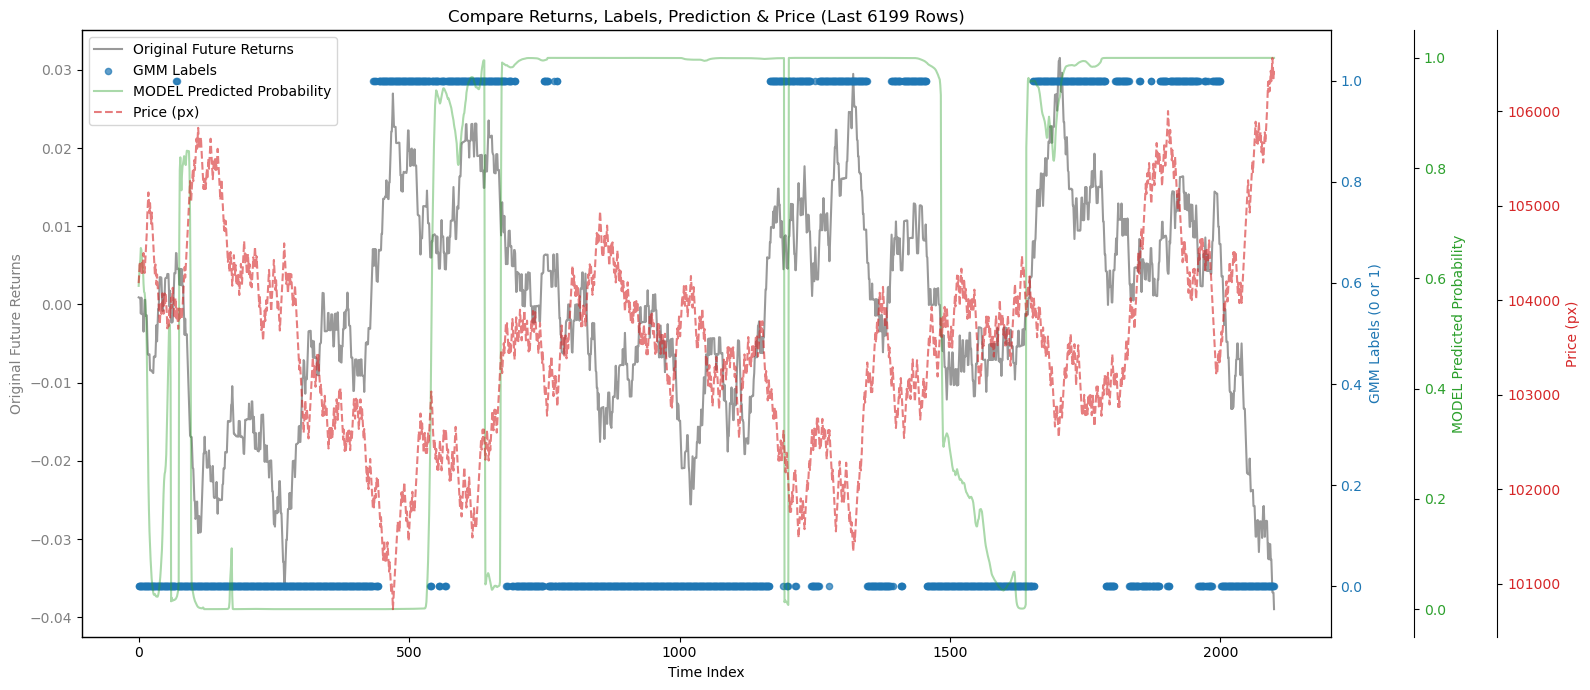

Test Week 4 Evaluation Completed
Fold 2: Train 2~4, Val 5, Test 6
Train: 2025-04-21 00:06:22.525000 to 2025-05-11 23:57:01.156000
Val: 2025-05-12 00:05:11.740000 to 2025-05-18 23:59:34.191000
Test: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000
GMM 分量均值: [ 0.01632786 -0.0013617 ]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.016328) => 二元标签: 1
GMM 内部标签 1 (均值: -0.001362) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.02333023 0.02322597 0.02093347 0.01881336 0.01673327 0.01459355
 0.01249175 0.01245281 0.01032588 0.00823417]
训练集GMM标签: [0 0 0 0 0 0 0 0 0 1]
训练集二元标签: [1 1 1 1 1 1 1 1 1 0]

测试集原始收益: [-0.04060904 -0.04059644 -0.03862709 -0.03855652 -0.03859678 -0.03860481
 -0.03861156 -0.04055314 -0.04250194 -0.04241047]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.66284 | val_0_accuracy: 0.50524 |  0:00:00s
epoch 1  | loss: 0.49041 | val_0_accuracy: 0.55048 |  0:00:01s
epoch 2  | loss: 0.46441 | val_0_accuracy: 0.68095 |  0:00:01s
epoch 3  | loss: 0.38697 | val_0_accuracy: 0.48238 |  0:00:02s
epoch 4  | loss: 0.4402  | val_0_accuracy: 0.45333 |  0:00:02s
epoch 5  | loss: 0.39972 | val_0_accuracy: 0.45714 |  0:00:03s
epoch 6  | loss: 0.39635 | val_0_accuracy: 0.42286 |  0:00:03s
epoch 7  | loss: 0.41649 | val_0_accuracy: 0.48952 |  0:00:04s
epoch 8  | loss: 0.45851 | val_0_accuracy: 0.45905 |  0:00:05s
epoch 9  | loss: 0.40094 | val_0_accuracy: 0.53905 |  0:00:05s
epoch 10 | loss: 0.39653 | val_0_accuracy: 0.48095 |  0:00:06s
epoch 11 | loss: 0.38085 | val_0_accuracy: 0.49952 |  0:00:06s
epoch 12 | loss: 0.33203 | val_0_accuracy: 0.53095 |  0:00:07s
epoch 13 | loss: 0.31095 | val_0_accuracy: 0.59857 |  0:00:07s
epoch 14 | loss: 0.30753 | val_0_accuracy: 0.61333 |  0:00:08s
epoch 15 | loss: 0.27031 | val_0_accuracy: 0.47095 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.7471
✅ 自信预测准确率: 0.6586 (阈值 0.15-0.85)
📈 出手率: 57.19%

🧮 自信预测混淆矩阵:
[[709 142]
 [268  82]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.73      0.83      0.78       851
           1       0.37      0.23      0.29       350

    accuracy                           0.66      1201
   macro avg       0.55      0.53      0.53      1201
weighted avg       0.62      0.66      0.63      1201



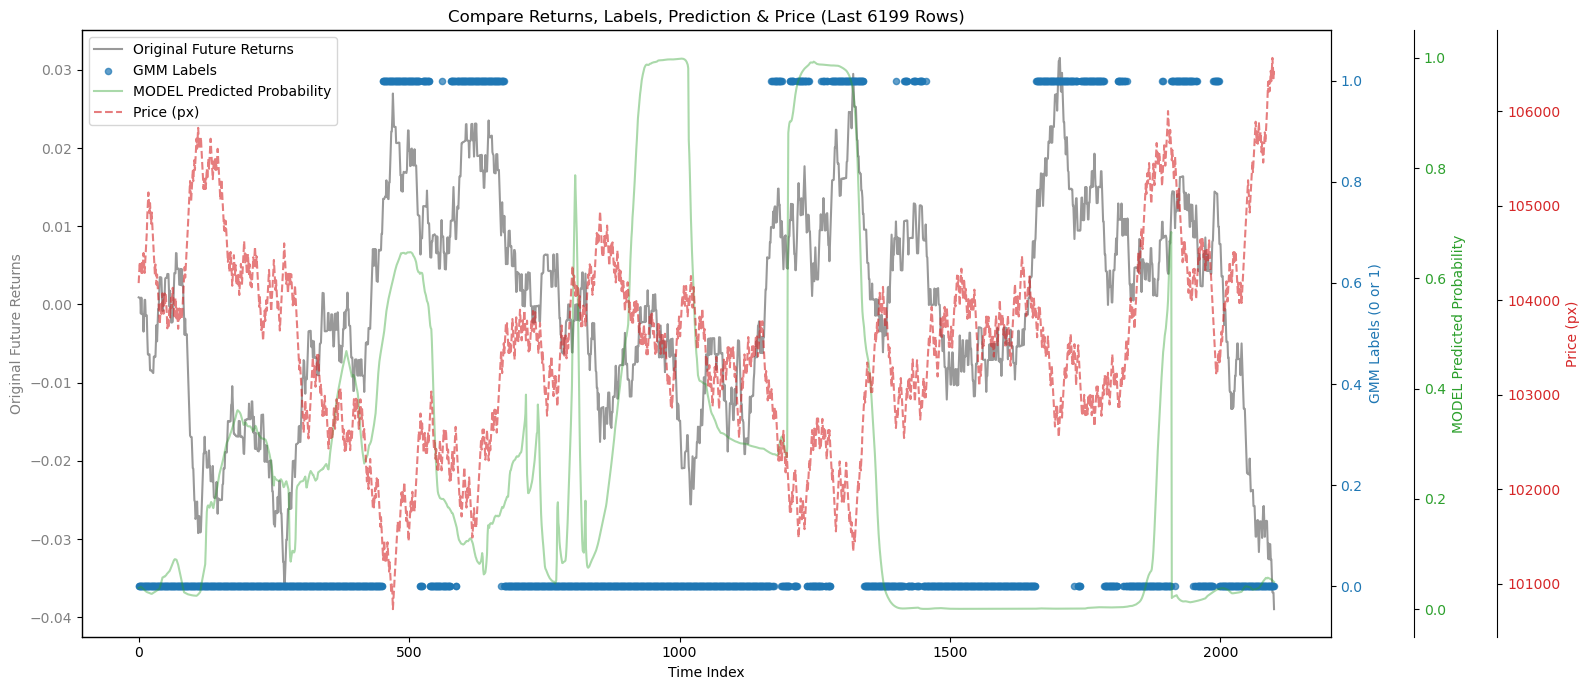


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5144
✅ 自信预测准确率: 0.5170 (阈值 0.15-0.85)
📈 出手率: 68.69%

🧮 自信预测混淆矩阵:
[[539 749]
 [332 618]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.62      0.42      0.50      1288
           1       0.45      0.65      0.53       950

    accuracy                           0.52      2238
   macro avg       0.54      0.53      0.52      2238
weighted avg       0.55      0.52      0.51      2238



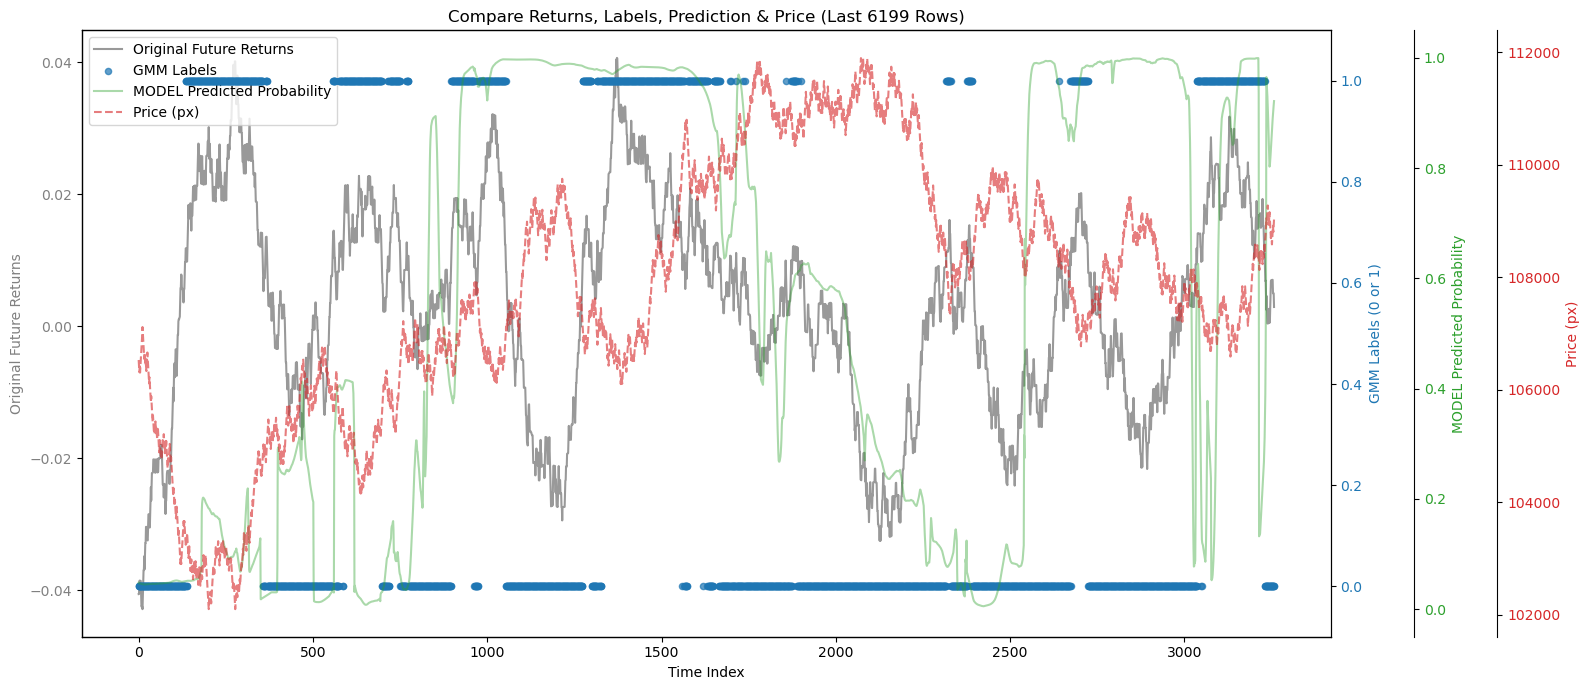

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 1.7394  |  0:00:00s
epoch 1  | loss: 0.61988 |  0:00:00s
epoch 2  | loss: 0.49401 |  0:00:00s
epoch 3  | loss: 0.56584 |  0:00:00s
epoch 4  | loss: 0.51706 |  0:00:00s
epoch 5  | loss: 0.43709 |  0:00:00s
epoch 6  | loss: 0.39206 |  0:00:00s
epoch 7  | loss: 0.37584 |  0:00:00s
epoch 8  | loss: 0.34918 |  0:00:00s
epoch 9  | loss: 0.32551 |  0:00:00s
epoch 10 | loss: 0.31435 |  0:00:01s
epoch 11 | loss: 0.30031 |  0:00:01s
epoch 12 | loss: 0.27867 |  0:00:01s
epoch 13 | loss: 0.2695  |  0:00:01s
epoch 14 | loss: 0.24465 |  0:00:01s
epoch 15 | loss: 0.24389 |  0:00:01s
epoch 16 | loss: 0.23234 |  0:00:01s
epoch 17 | loss: 0.23036 |  0:00:01s
epoch 18 | loss: 0.22237 |  0:00:01s
epoch 19 | loss: 0.21249 |  0:00:01s
epoch 20 | loss: 0.21057 |  0:00:01s
epoch 21 | loss: 0.2258  |  0:00:02s
epoch 22 | loss: 0.21394 |  0:00:02s
epoch 23 | loss: 0.20722 |  0:00:02s
epoch 24 | loss: 0.20147 |  0:00:02s
epoch 25 | loss: 0.20264 |  0:00:02s
epoch 26 | loss: 0.19866 |  0:00:02s
e

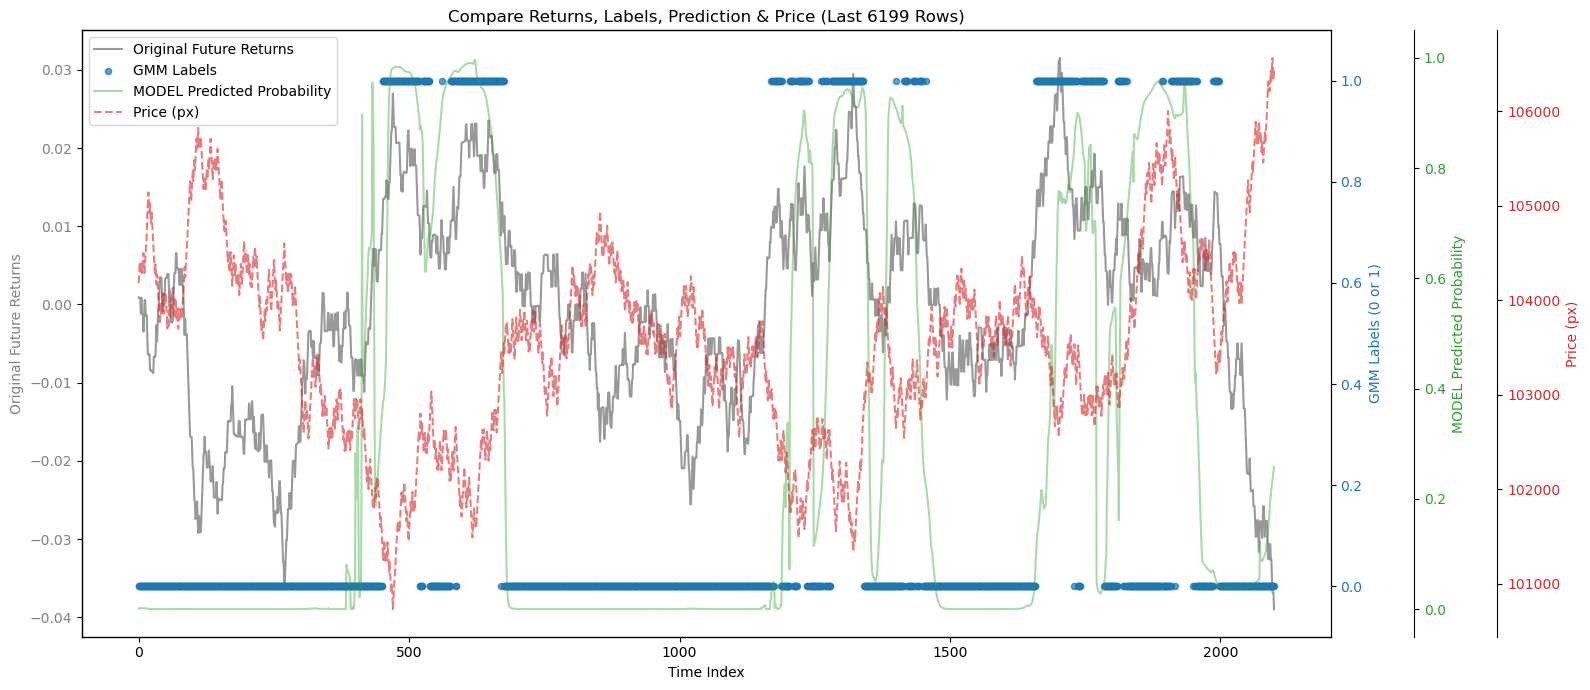


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.6323
✅ 自信预测准确率: 0.6357 (阈值 0.15-0.85)
📈 出手率: 96.56%

🧮 自信预测混淆矩阵:
[[1976    0]
 [1146   24]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.63      1.00      0.78      1976
           1       1.00      0.02      0.04      1170

    accuracy                           0.64      3146
   macro avg       0.82      0.51      0.41      3146
weighted avg       0.77      0.64      0.50      3146



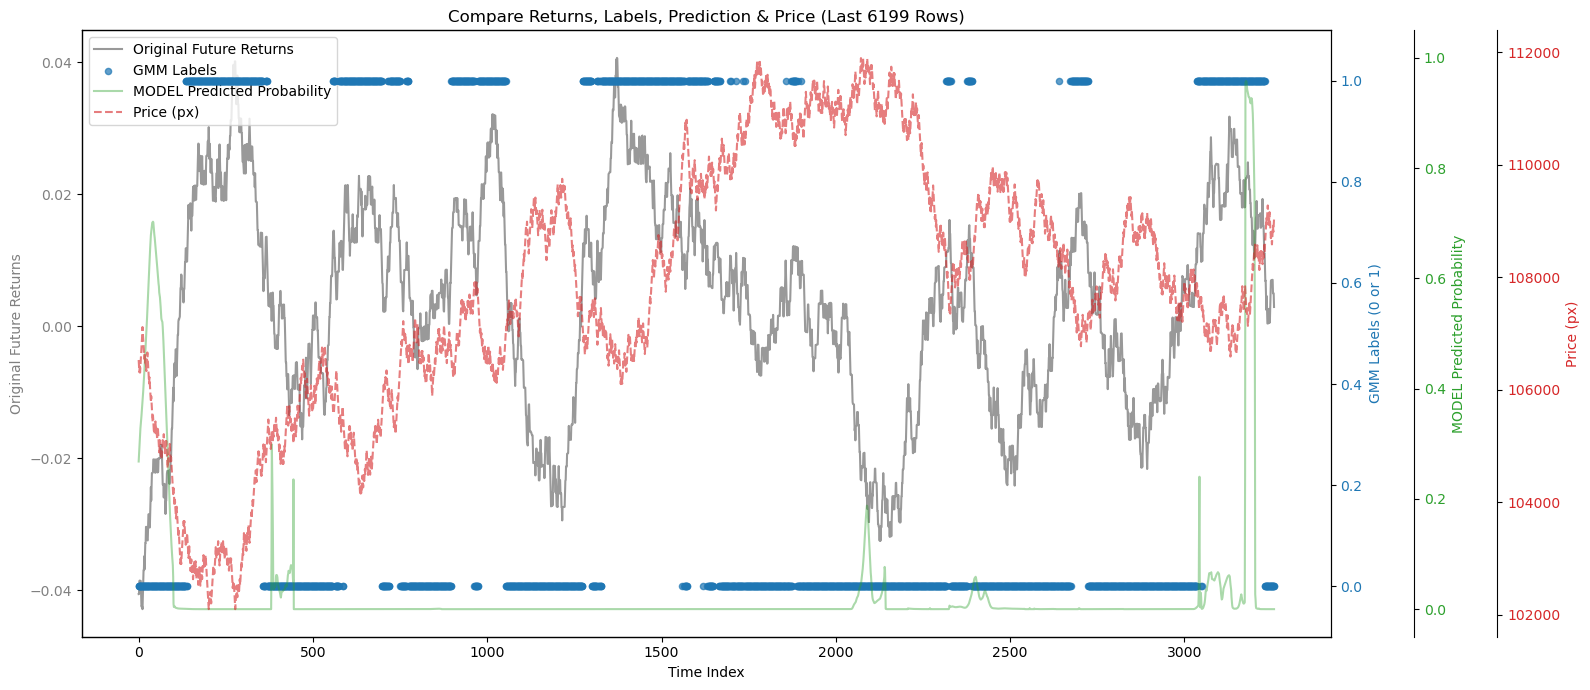

Test Week 5 Evaluation Completed
Fold 3: Train 3~5, Val 6, Test 7
Train: 2025-04-28 00:06:59.957000 to 2025-05-18 23:59:34.191000
Val: 2025-05-19 00:00:37.074000 to 2025-05-25 23:57:24.031000
Test: 2025-05-26 00:01:11.960000 to 2025-06-01 23:52:35.215000
GMM 分量均值: [ 0.01313789 -0.00331479]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.013138) => 二元标签: 1
GMM 内部标签 1 (均值: -0.003315) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [0.00323932 0.00326096 0.00553419 0.0076164  0.00771151 0.0076466
 0.01014335 0.008064   0.01017145 0.01224453]
训练集GMM标签: [1 1 1 0 0 0 0 0 0 0]
训练集二元标签: [0 0 0 1 1 1 1 1 1 1]

测试集原始收益: [ 0.00356648  0.0035831   0.00354169  0.00354182  0.00359794  0.00356133
  0.00148937 -0.00083526 -0.00084724 -0.00080975]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.78004 | val_0_accuracy: 0.45549 |  0:00:00s
epoch 1  | loss: 0.57163 | val_0_accuracy: 0.42818 |  0:00:01s
epoch 2  | loss: 0.516   | val_0_accuracy: 0.53714 |  0:00:01s
epoch 3  | loss: 0.49708 | val_0_accuracy: 0.4825  |  0:00:02s
epoch 4  | loss: 0.48985 | val_0_accuracy: 0.49785 |  0:00:02s
epoch 5  | loss: 0.51465 | val_0_accuracy: 0.48343 |  0:00:03s
epoch 6  | loss: 0.48064 | val_0_accuracy: 0.59024 |  0:00:03s
epoch 7  | loss: 0.41679 | val_0_accuracy: 0.47053 |  0:00:04s
epoch 8  | loss: 0.41629 | val_0_accuracy: 0.49018 |  0:00:04s
epoch 9  | loss: 0.36938 | val_0_accuracy: 0.51105 |  0:00:05s
epoch 10 | loss: 0.36378 | val_0_accuracy: 0.46746 |  0:00:05s
epoch 11 | loss: 0.3246  | val_0_accuracy: 0.3318  |  0:00:06s
epoch 12 | loss: 0.30781 | val_0_accuracy: 0.34561 |  0:00:06s
epoch 13 | loss: 0.31496 | val_0_accuracy: 0.37723 |  0:00:07s
epoch 14 | loss: 0.32972 | val_0_accuracy: 0.46409 |  0:00:07s
epoch 15 | loss: 0.30897 | val_0_accuracy: 0.56998 |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)



=== tabnet 评估结果 ===
📊 全样本准确率: 0.6559
✅ 自信预测准确率: 0.6285 (阈值 0.15-0.85)
📈 出手率: 76.18%

🧮 自信预测混淆矩阵:
[[1169  260]
 [ 662  391]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.64      0.82      0.72      1429
           1       0.60      0.37      0.46      1053

    accuracy                           0.63      2482
   macro avg       0.62      0.59      0.59      2482
weighted avg       0.62      0.63      0.61      2482



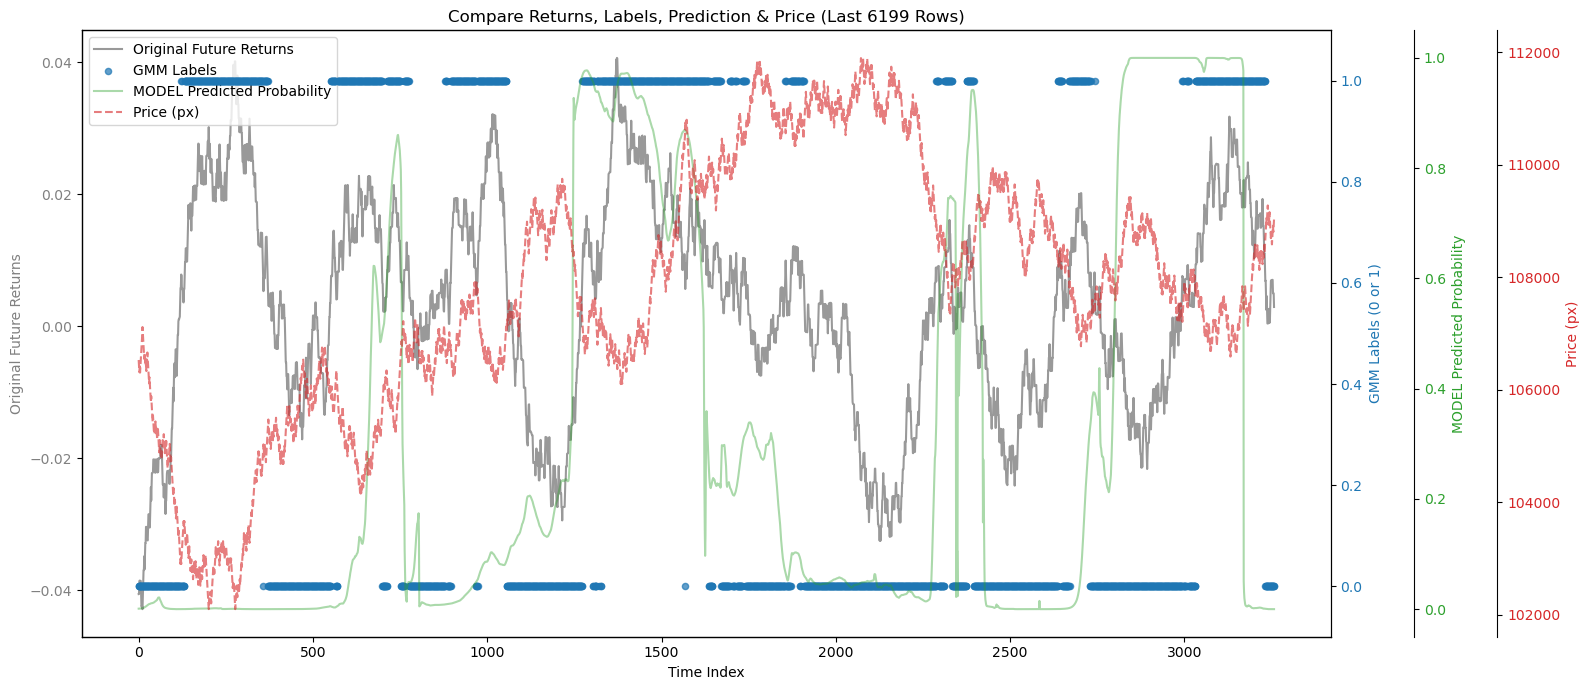


=== tabnet 评估结果 ===
📊 全样本准确率: 0.4592
✅ 自信预测准确率: 0.3933 (阈值 0.15-0.85)
📈 出手率: 80.71%

🧮 自信预测混淆矩阵:
[[512 853]
 [142 133]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.78      0.38      0.51      1365
           1       0.13      0.48      0.21       275

    accuracy                           0.39      1640
   macro avg       0.46      0.43      0.36      1640
weighted avg       0.67      0.39      0.46      1640



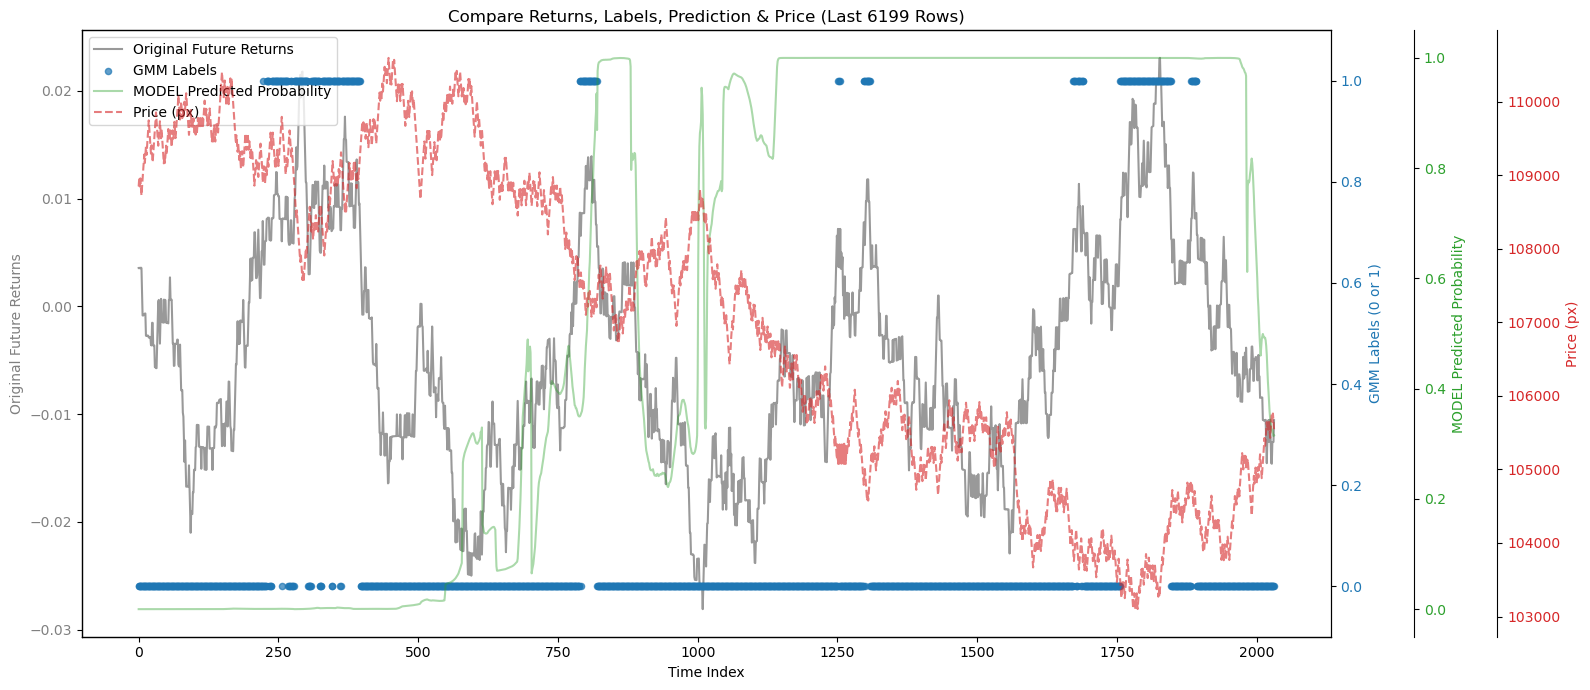

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.17612 |  0:00:00s
epoch 1  | loss: 0.80692 |  0:00:00s
epoch 2  | loss: 0.47936 |  0:00:00s
epoch 3  | loss: 0.43418 |  0:00:00s
epoch 4  | loss: 0.31094 |  0:00:00s
epoch 5  | loss: 0.31348 |  0:00:00s
epoch 6  | loss: 0.26468 |  0:00:00s
epoch 7  | loss: 0.26569 |  0:00:01s
epoch 8  | loss: 0.24492 |  0:00:01s
epoch 9  | loss: 0.24971 |  0:00:01s
epoch 10 | loss: 0.23638 |  0:00:01s
epoch 11 | loss: 0.22738 |  0:00:01s
epoch 12 | loss: 0.22128 |  0:00:01s
epoch 13 | loss: 0.22563 |  0:00:01s
epoch 14 | loss: 0.223   |  0:00:02s
epoch 15 | loss: 0.21989 |  0:00:02s
epoch 16 | loss: 0.22091 |  0:00:02s
epoch 17 | loss: 0.21846 |  0:00:02s
epoch 18 | loss: 0.22474 |  0:00:02s
epoch 19 | loss: 0.21635 |  0:00:02s
epoch 20 | loss: 0.20825 |  0:00:02s
epoch 21 | loss: 0.21626 |  0:00:03s
epoch 22 | loss: 0.20521 |  0:00:03s
epoch 23 | loss: 0.21316 |  0:00:03s
epoch 24 | loss: 0.21072 |  0:00:03s
epoch 25 | loss: 0.20229 |  0:00:03s
epoch 26 | loss: 0.21599 |  0:00:03s
e

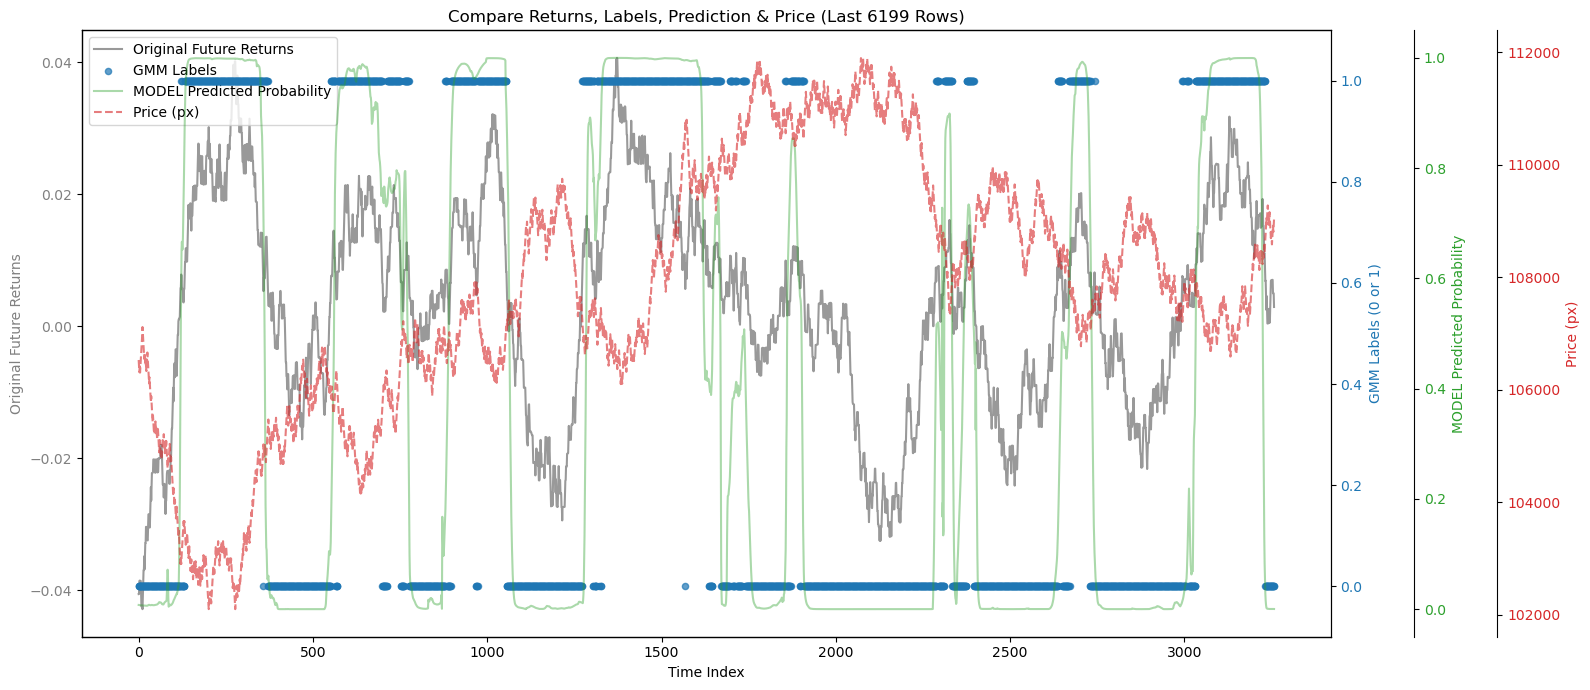


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.7175
✅ 自信预测准确率: 0.7475 (阈值 0.15-0.85)
📈 出手率: 77.76%

🧮 自信预测混淆矩阵:
[[1181  121]
 [ 278    0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1302
           1       0.00      0.00      0.00       278

    accuracy                           0.75      1580
   macro avg       0.40      0.45      0.43      1580
weighted avg       0.67      0.75      0.70      1580



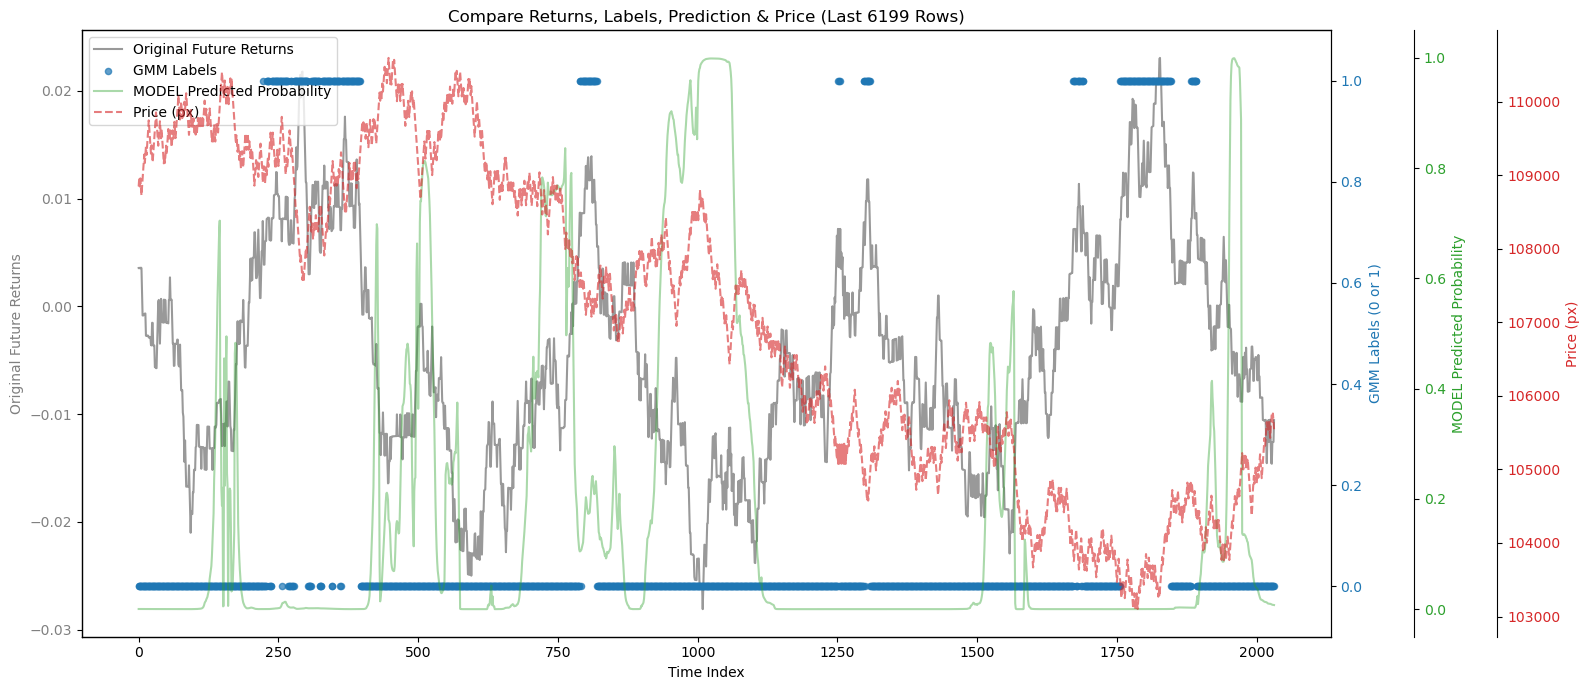

Test Week 6 Evaluation Completed
Fold 4: Train 4~6, Val 7, Test 8
Train: 2025-05-05 00:01:39.539000 to 2025-05-25 23:57:24.031000
Val: 2025-05-26 00:01:11.960000 to 2025-06-01 23:52:35.215000
Test: 2025-06-02 00:06:44.065000 to 2025-06-03 18:39:51.056000
GMM 分量均值: [ 0.01293598 -0.00388073]
上涨标签: 0, 下跌标签: 1

--- GMM 原始标签 => 最终二元标签映射 ---
GMM 内部标签 0 (均值: 0.012936) => 二元标签: 1
GMM 内部标签 1 (均值: -0.003881) => 二元标签: 0

--- 示例标签 ---
训练集原始收益: [ 0.00368397  0.00369302  0.00160607 -0.0004681  -0.00256658 -0.00250895
 -0.00455572 -0.00659495 -0.00867212 -0.00654371]
训练集GMM标签: [1 1 1 1 1 1 1 1 1 1]
训练集二元标签: [0 0 0 0 0 0 0 0 0 0]

测试集原始收益: [-0.00880809 -0.00879709 -0.01095481 -0.01114951 -0.01117422 -0.01317441
 -0.01115228 -0.00916311 -0.01117488 -0.01112979]
测试集GMM标签: [1 1 1 1 1 1 1 1 1 1]
测试集二元标签: [0 0 0 0 0 0 0 0 0 0]


C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.7973  | val_0_accuracy: 0.53986 |  0:00:00s
epoch 1  | loss: 0.59538 | val_0_accuracy: 0.50787 |  0:00:01s
epoch 2  | loss: 0.60129 | val_0_accuracy: 0.48573 |  0:00:01s
epoch 3  | loss: 0.55947 | val_0_accuracy: 0.57037 |  0:00:02s
epoch 4  | loss: 0.54269 | val_0_accuracy: 0.25492 |  0:00:02s
epoch 5  | loss: 0.52576 | val_0_accuracy: 0.2185  |  0:00:03s
epoch 6  | loss: 0.47052 | val_0_accuracy: 0.31545 |  0:00:03s
epoch 7  | loss: 0.46867 | val_0_accuracy: 0.16339 |  0:00:04s
epoch 8  | loss: 0.41516 | val_0_accuracy: 0.20472 |  0:00:05s
epoch 9  | loss: 0.4059  | val_0_accuracy: 0.2687  |  0:00:05s
epoch 10 | loss: 0.38621 | val_0_accuracy: 0.19341 |  0:00:06s
epoch 11 | loss: 0.3756  | val_0_accuracy: 0.21654 |  0:00:06s
epoch 12 | loss: 0.40105 | val_0_accuracy: 0.25984 |  0:00:07s
epoch 13 | loss: 0.39114 | val_0_accuracy: 0.27608 |  0:00:08s
epoch 14 | loss: 0.39566 | val_0_accuracy: 0.2874  |  0:00:08s
epoch 15 | loss: 0.38174 | val_0_accuracy: 0.2628  |  0

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetr


=== tabnet 评估结果 ===
📊 全样本准确率: 0.5704
✅ 自信预测准确率: 0.3613 (阈值 0.15-0.85)
📈 出手率: 19.34%

🧮 自信预测混淆矩阵:
[[  0 251]
 [  0 142]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       251
           1       0.36      1.00      0.53       142

    accuracy                           0.36       393
   macro avg       0.18      0.50      0.27       393
weighted avg       0.13      0.36      0.19       393



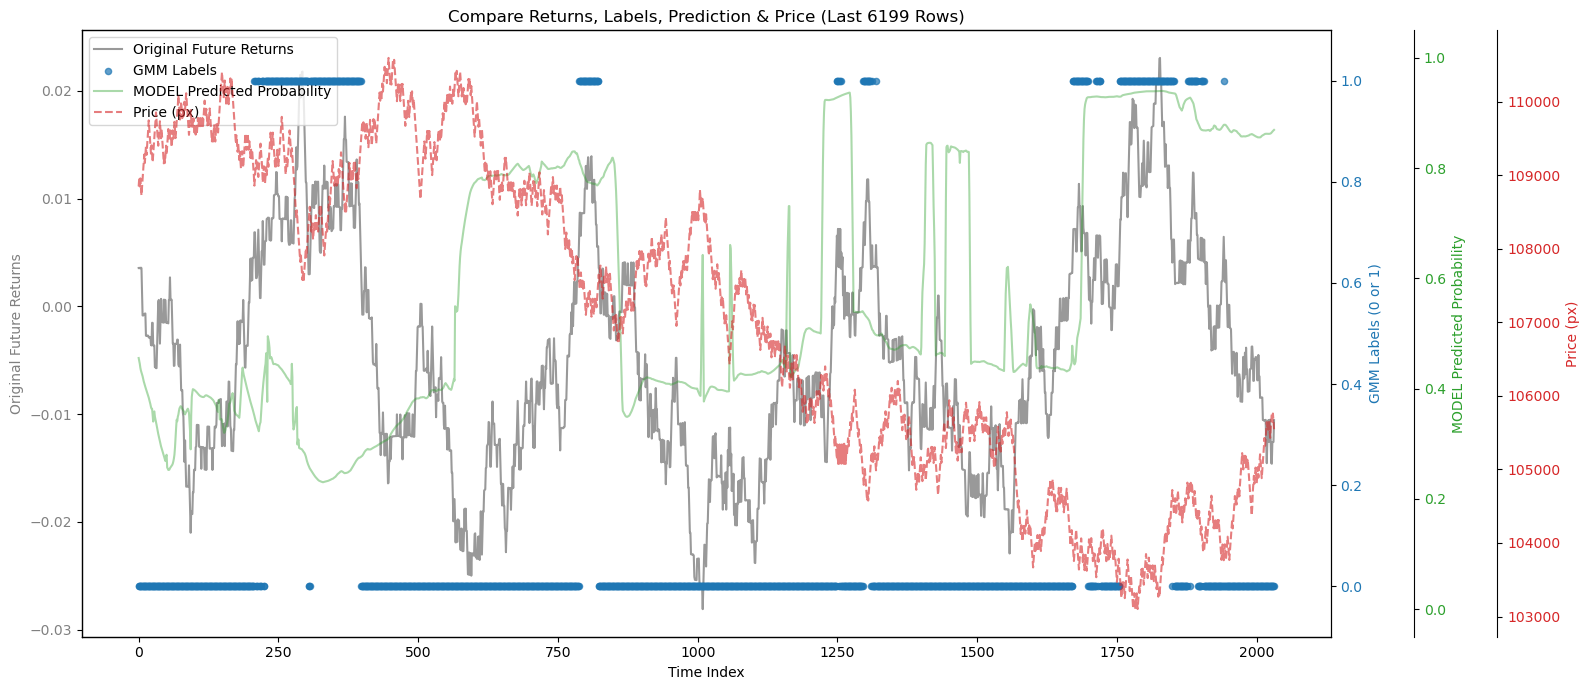

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


=== tabnet 评估结果 ===
📊 全样本准确率: 0.4499
✅ 自信预测准确率: 0.4499 (阈值 0.15-0.85)
📈 出手率: 100.00%

🧮 自信预测混淆矩阵:
[[  0 225]
 [  0 184]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       225
           1       0.45      1.00      0.62       184

    accuracy                           0.45       409
   macro avg       0.22      0.50      0.31       409
weighted avg       0.20      0.45      0.28       409



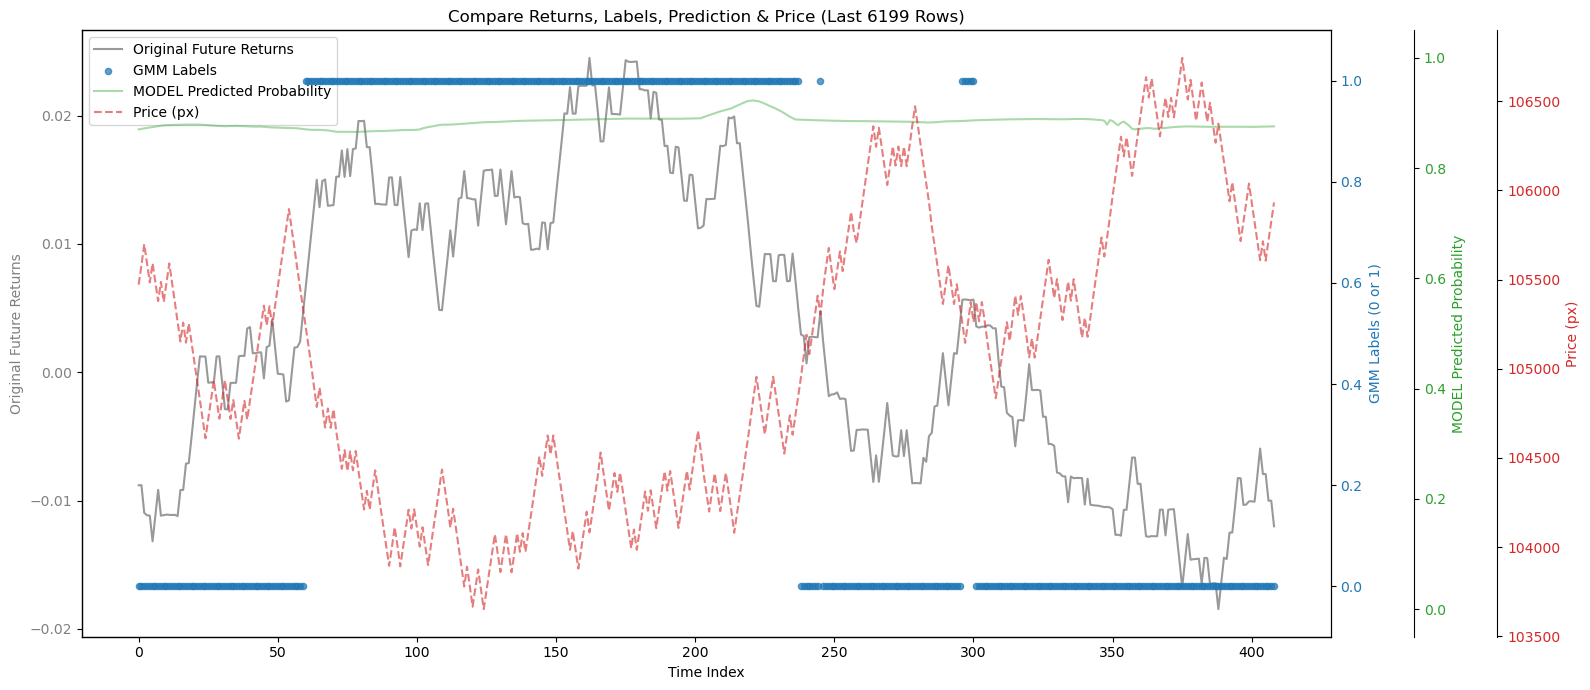

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\pytorch_tabnet\abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 2.71906 |  0:00:00s
epoch 1  | loss: 1.64468 |  0:00:00s
epoch 2  | loss: 0.97955 |  0:00:00s
epoch 3  | loss: 0.57448 |  0:00:00s
epoch 4  | loss: 0.42841 |  0:00:00s
epoch 5  | loss: 0.35159 |  0:00:00s
epoch 6  | loss: 0.33313 |  0:00:00s
epoch 7  | loss: 0.37254 |  0:00:00s
epoch 8  | loss: 0.28667 |  0:00:00s
epoch 9  | loss: 0.30525 |  0:00:00s
epoch 10 | loss: 0.23833 |  0:00:00s
epoch 11 | loss: 0.25534 |  0:00:00s
epoch 12 | loss: 0.27755 |  0:00:00s
epoch 13 | loss: 0.26012 |  0:00:00s
epoch 14 | loss: 0.24067 |  0:00:00s
epoch 15 | loss: 0.22741 |  0:00:00s
epoch 16 | loss: 0.22103 |  0:00:00s
epoch 17 | loss: 0.19572 |  0:00:00s
epoch 18 | loss: 0.19139 |  0:00:00s
epoch 19 | loss: 0.19456 |  0:00:00s
epoch 20 | loss: 0.17052 |  0:00:00s
epoch 21 | loss: 0.18525 |  0:00:01s
epoch 22 | loss: 0.1848  |  0:00:01s
epoch 23 | loss: 0.17763 |  0:00:01s
epoch 24 | loss: 0.16797 |  0:00:01s
epoch 25 | loss: 0.18196 |  0:00:01s
epoch 26 | loss: 0.19044 |  0:00:01s
e

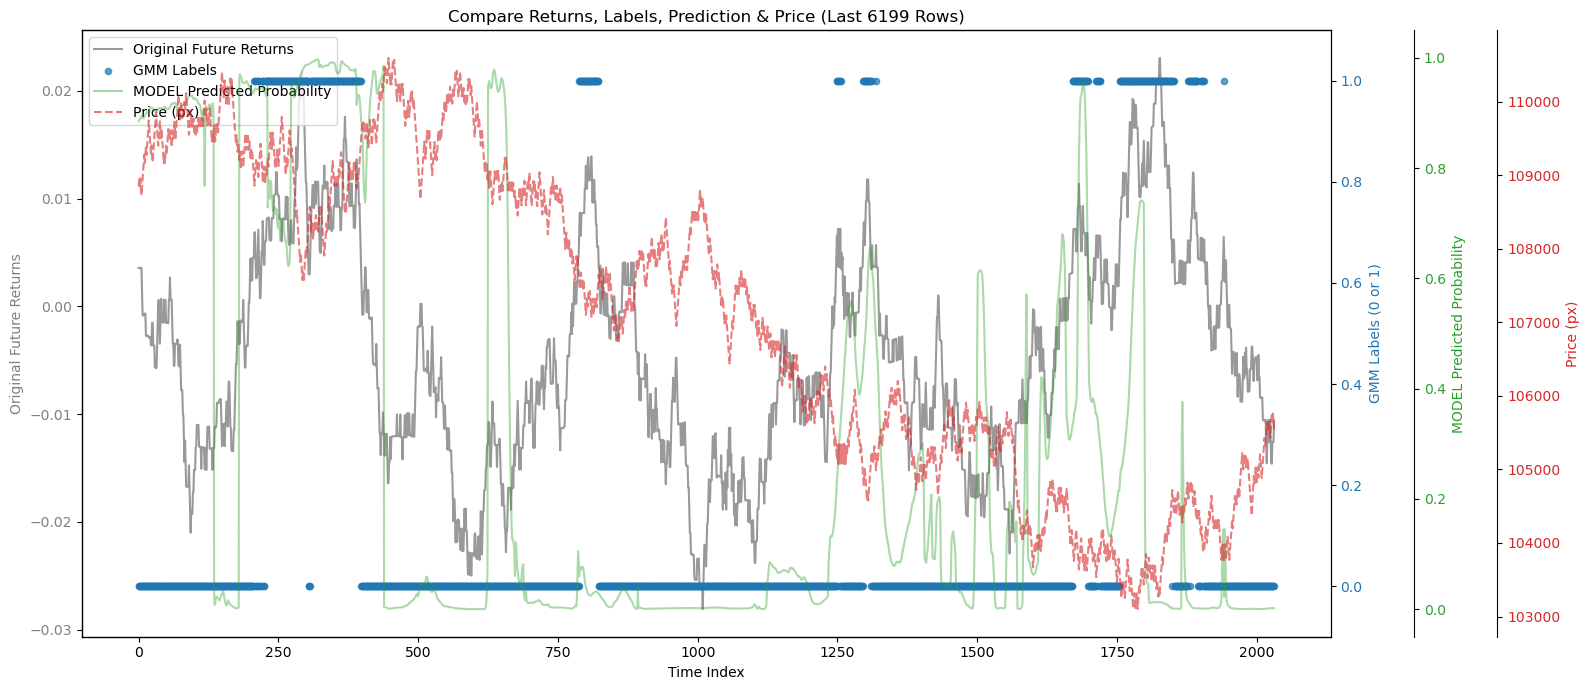

C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Grayman\anaconda3\envs\machine_learning\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.


=== tab_inc 评估结果 ===
📊 全样本准确率: 0.5501
✅ 自信预测准确率: 0.5501 (阈值 0.15-0.85)
📈 出手率: 100.00%

🧮 自信预测混淆矩阵:
[[225   0]
 [184   0]]

📝 分类报告:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       225
           1       0.00      0.00      0.00       184

    accuracy                           0.55       409
   macro avg       0.28      0.50      0.35       409
weighted avg       0.30      0.55      0.39       409



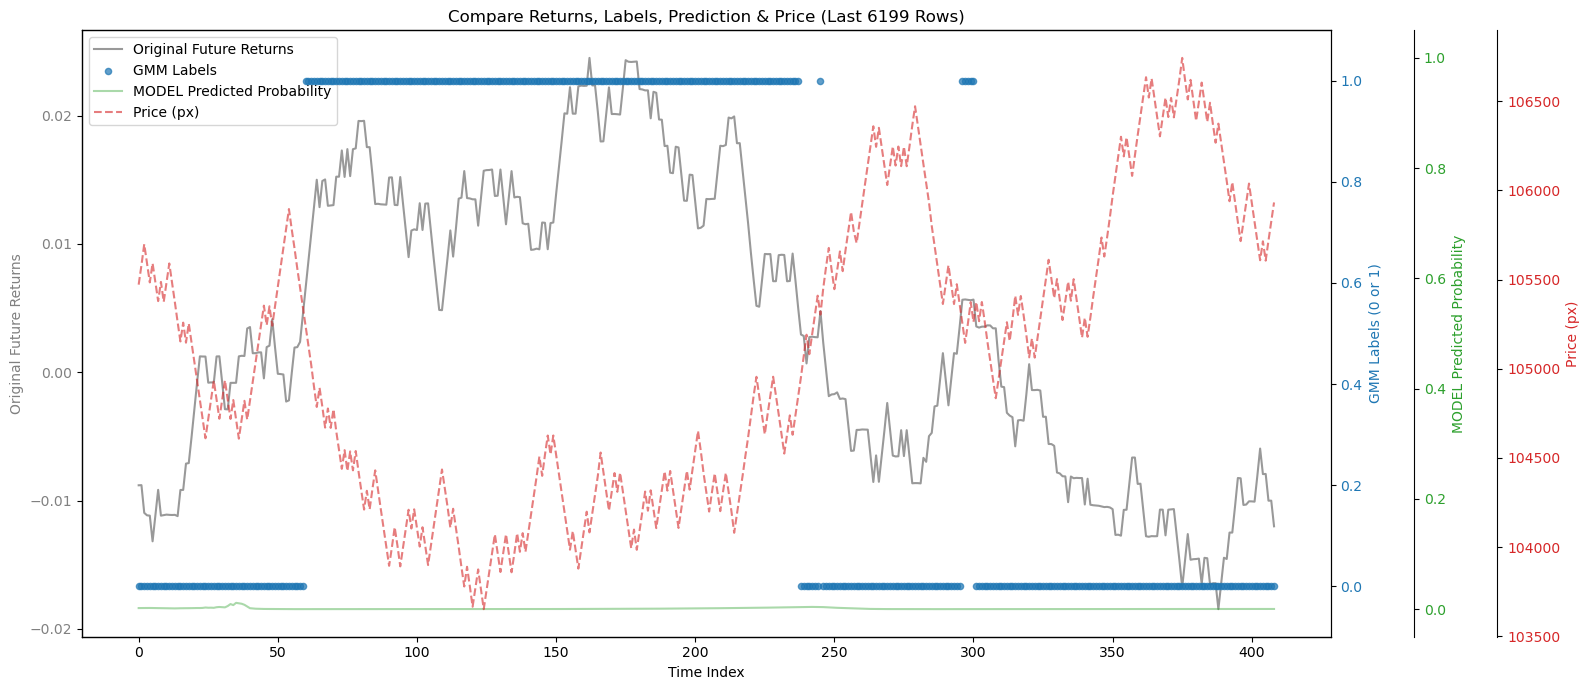

Test Week 7 Evaluation Completed


In [32]:
n_train_weeks = 3 # 可配置
n_val_weeks = 1    # 一般 1 周验证
n_test_weeks = 1   # 后 1 周做 test

exclude_prefixes = ['px', 'timestamp', 'timestamp_dt', 'symbol']
target_col = f"future_return_{avg_steps_pct}"
feature_cols = [
    col for col in origin_df.columns
    if col.endswith("_scaled") 
        and col.startswith("z_") 
        and all(not col.startswith(prefix) for prefix in exclude_prefixes)
        and not col.startswith("future_return_")
        and col != "px"
]
# feature_cols = ["z_oi_di_scaled"]
results = []

tab_inc = None
tab_inc_flag = 0

for i in range(len(weekly_dataframes) - n_train_weeks - n_val_weeks - n_test_weeks + 1):
    train_dfs = weekly_dataframes[i : i + n_train_weeks]
    val_dfs = weekly_dataframes[i + n_train_weeks : i + n_train_weeks + n_val_weeks]
    test_dfs = weekly_dataframes[i + n_train_weeks + n_val_weeks : i + n_train_weeks + n_val_weeks + n_test_weeks]
    
    train_df = pl.concat(train_dfs)
    val_df = pl.concat(val_dfs)
    test_df = pl.concat(test_dfs)

    print("=" * 60)
    print(f"Fold {i}: Train {i}~{i+n_train_weeks-1}, Val {i+n_train_weeks}, Test {i+n_train_weeks+1}")
    print("Train:", train_df['timestamp_dt'][0], "to", train_df['timestamp_dt'][-1])
    print("Val:", val_df['timestamp_dt'][0], "to", val_df['timestamp_dt'][-1])
    print("Test:", test_df['timestamp_dt'][0], "to", test_df['timestamp_dt'][-1])
    
    # 处理 train
    train_df_processed = train_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_train = train_df_processed[feature_cols]
    y_train = train_df_processed[target_col]
    px_train = train_df_processed['px']

    # 处理 val
    val_df_processed = val_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_val = val_df_processed[feature_cols]
    y_val = val_df_processed[target_col]
    px_val = val_df_processed['px']

    # 处理 test
    test_df_processed = test_df.sort('timestamp').drop_nulls(subset=feature_cols + [target_col, 'px']).to_pandas()
    X_test = test_df_processed[feature_cols]
    y_test = test_df_processed[target_col]
    px_test = test_df_processed['px']
    
    
    y_train_bin, y_val_bin, y_test_bin, gmm_model = gmm_label_binarize(y_train, y_val, y_test, verbose=True)

    # modellllllll
    up_thresh = 0.15
    lower_thresh = 0.85
    
    # # #LGBM
    # lgb_model = lgb.LGBMClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbose=-1)
    # lgb_model.fit(
    #     X_train, y_train_bin,
    #     eval_set=[(X_val, y_val_bin)],
    #     eval_metric='binary_logloss',
    # )
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=lgb_model.predict_proba(X_val)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, lgb_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # lgb_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=lgb_model.predict_proba(X_test)[:, 1],
    #     model_name="lgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, lgb_model.predict_proba(X_test)[:, 1], px_test, n=6199)


    # # CAT
    # cat_model = CatBoostClassifier(iterations=2000, learning_rate=0.005, depth=9, verbose=0)
    # cat_model.fit(
    #     X_train, y_train_bin,
    # )

    # cat_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=cat_model.predict_proba(X_val)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, cat_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    
    # cat_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=cat_model.predict_proba(X_test)[:, 1],
    #     model_name="cat_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, cat_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    # # XGB
    # xgb_model = xgb.XGBClassifier(n_estimators=2000, learning_rate=0.005, max_depth=9, verbosity=0, use_label_encoder=False)
    # xgb_model.fit(
    #     X_train, y_train_bin,
    # )

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_val_bin,
    #     y_pred_proba=xgb_model.predict_proba(X_val)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_val, y_val_bin, xgb_model.predict_proba(X_val)[:, 1], px_val, n=6199)
    

    # xgb_eval = evaluate_with_confidence(
    #     y_true=y_test_bin,
    #     y_pred_proba=xgb_model.predict_proba(X_test)[:, 1],
    #     model_name="xgb_model",
    #     lower_thresh=up_thresh,
    #     upper_thresh=lower_thresh,
    #     print_report=True,
    # )
    # plot_last_n_rows_with_px(y_test, y_test_bin, xgb_model.predict_proba(X_test)[:, 1], px_test, n=6199)

    
    # Label Encode y（如果是0/1就不用）
    y_train_enc = y_train_bin.astype(int)
    y_val_enc = y_val_bin.astype(int)
    
    # TabNet 训练
    tabnet = TabNetClassifier(
        n_d=16,
        n_a=16,
        n_steps=7,
        device_name='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=1,
    )
    tabnet.fit(
        X_train=X_train.values, y_train=y_train_enc,
        eval_set=[(X_val.values, y_val_enc)],
        eval_metric=['accuracy'],
        max_epochs=300,
        patience=30,
        batch_size=512,
        virtual_batch_size=256,
    )

    tabnet_eval = evaluate_with_confidence(
        y_true=y_val_bin,
        y_pred_proba=tabnet.predict_proba(X_val.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_val, y_val_bin, tabnet.predict_proba(X_val.values)[:, 1], px_val, n=6199)


    tabnet_eval = evaluate_with_confidence(
        y_true=y_test_bin,
        y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
        model_name="tabnet",
        lower_thresh=up_thresh,
        upper_thresh=lower_thresh,
        print_report=True,
    )
    plot_last_n_rows_with_px(y_test, y_test_bin, tabnet.predict_proba(X_test.values)[:, 1], px_test, n=6199)


    # TabNet_incremental 训练
    if tab_inc_flag == 0:
        tab_inc_flag = 1
        tab_inc = TabNetClassifier(
            n_d=16,
            n_a=16,
            n_steps=7,
            device_name='cuda' if torch.cuda.is_available() else 'cpu',
            verbose=1,
        )
        tab_inc.fit(
            X_train=X_train.values, y_train=y_train_enc,
            eval_set=[(X_val.values, y_val_enc)],
            eval_metric=['accuracy'],
            max_epochs=300,
            patience=30,
            batch_size=512,
            virtual_batch_size=256,
        )
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val_bin,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_val, y_val_bin, tab_inc.predict_proba(X_val.values)[:, 1], px_val, n=6199)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test_bin,
            y_pred_proba=tabnet.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test_bin, tab_inc.predict_proba(X_test.values)[:, 1], px_test, n=6199)
        tab_inc.fit(X_val.values, y_val_enc, warm_start=True)

    else:
        tab_inc.fit(X_val.values, y_val_enc, warm_start=True)
        
        tabnet_eval = evaluate_with_confidence(
            y_true=y_val_bin,
            y_pred_proba=tab_inc.predict_proba(X_val.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_val, y_val_bin, tab_inc.predict_proba(X_val.values)[:, 1], px_val, n=6199)
    
    
        tabnet_eval = evaluate_with_confidence(
            y_true=y_test_bin,
            y_pred_proba=tab_inc.predict_proba(X_test.values)[:, 1],
            model_name="tab_inc",
            lower_thresh=up_thresh,
            upper_thresh=lower_thresh,
            print_report=True,
        )
        plot_last_n_rows_with_px(y_test, y_test_bin, tab_inc.predict_proba(X_test.values)[:, 1], px_test, n=6199)
    
    week_results = {
        'train_period': f"{train_df['timestamp_dt'][0]} to {train_df['timestamp_dt'][-1]}",
        'test_period': f"{test_df['timestamp_dt'][0]} to {test_df['timestamp_dt'][-1]}",
        'LGBM': lgb_eval,
        'CatBoost': cat_model,
        'XGBoost': xgb_eval,
        'TabNet': tabnet_eval,
    }
    
    results.append(week_results)
    print(f"Test Week {i+n_train_weeks} Evaluation Completed")

    